# Instalação do Ambiente PySpark e demais dependências

In [1]:
# instalar as dependências
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.3.0/spark-3.3.0-bin-hadoop2.tgz 
!tar xf spark-3.3.0-bin-hadoop2.tgz

In [2]:
# configurar as variáveis de ambiente e o Spark
import os
import sys
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.0-bin-hadoop2.tgz"

In [3]:
!pip install -q findspark

# tornar o pyspark "importável"
import findspark
findspark.init('spark-3.3.0-bin-hadoop2')

In [4]:
# iniciar uma sessão local
from pyspark.sql import SparkSession,SQLContext

spark = SparkSession.builder.master("local[*]").appName("DadosBrazilianStockMarket").getOrCreate()

In [5]:
# Instalando o yahoo finance
!pip install yfinance --upgrade --no-cache-dir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 6.7 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [6]:
import matplotlib.pyplot as plt

In [7]:
import pyspark
from pyspark.sql import SparkSession

In [8]:
import pyspark.pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf 
import requests

In [9]:
import numpy as np

In [10]:
from pyspark.sql.types import StructType,StructField, StringType

In [11]:
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [12]:
import plotly.offline as py
import plotly.graph_objs as go

In [13]:
from google.colab import files

# Aquisição de Dados

In [14]:
url = "https://investnews.com.br/financas/veja-a-lista-completa-dos-bdrs-disponiveis-para-pessoas-fisicas-na-b3/"
r = requests.get(url)
html = r.text
df_nomes_tickers = pd.read_html(html, header=0)[0]
df_nomes_tickers.rename(columns={'EMPRESA': 'Empresa', 'CÓDIGO': 'Codigo','SETOR': 'Setor','PAÍS DE ORIGEM': 'Pais_de_origem'}, inplace=True)
df_nomes_tickers.head(10)

,Empresa,Codigo,Setor,Pais_de_origem
0,3M,MMMC34,Indústria diversificada,EUA
1,AB INBEV,ABUD34,Bebidas,Bélgica
2,ABB LTD,A1BB34,Industrial,Switzerland
3,ABBOTT,ABTT34,Farmacêuticos,EUA
4,ABBVIE,ABBV34,Medicamentos e Outros Produtos,EUA
5,ABIOMED INC,A1BM34,Saúde,EUA
6,ACTIVISION,ATVI34,Tecnologia,EUA
7,ADOBE INC,ADBE34,Tecnologia,EUA
8,ADVANCE AUTO PARTS INC,A1AP34,Peças Automotivas,EUA
9,ADVANCED MIC,A1MD34,Tecnologia,EUA


In [15]:
df_nomes_tickers['Codigo']=df_nomes_tickers['Codigo']+'.SA'
xd=df_nomes_tickers.to_spark()
xd.show()

spark-3.3.0-bin-hadoop2/python/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning:

If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.



+--------------------+---------+--------------------+--------------+
|             Empresa|   Codigo|               Setor|Pais_de_origem|
+--------------------+---------+--------------------+--------------+
|                  3M|MMMC34.SA|Indústria diversi...|           EUA|
|            AB INBEV|ABUD34.SA|             Bebidas|       Bélgica|
|             ABB LTD|A1BB34.SA|          Industrial|   Switzerland|
|              ABBOTT|ABTT34.SA|       Farmacêuticos|           EUA|
|              ABBVIE|ABBV34.SA|Medicamentos e Ou...|           EUA|
|         ABIOMED INC|A1BM34.SA|               Saúde|           EUA|
|          ACTIVISION|ATVI34.SA|          Tecnologia|           EUA|
|           ADOBE INC|ADBE34.SA|          Tecnologia|           EUA|
|ADVANCE AUTO PART...|A1AP34.SA|   Peças Automotivas|           EUA|
|        ADVANCED MIC|A1MD34.SA|          Tecnologia|           EUA|
|            AEGON NV|A1EG34.SA|          Financeiro|       Holanda|
|            AES CORP|A1ES34.SA|  

In [16]:
xd.createOrReplaceTempView("xd")

In [17]:
analise_total_query=spark.sql("select count(distinct Empresa) as Total_de_Empresas, count(distinct Setor) as Setores,count(distinct Pais_de_origem) as Paises  from xd")

In [18]:
analise_total_query.show(10,False)

+-----------------+-------+------+
|Total_de_Empresas|Setores|Paises|
+-----------------+-------+------+
|707              |206    |42    |
+-----------------+-------+------+



In [19]:
ticket=xd.select('Codigo').toPandas()['Codigo']
ticket_list=list(ticket)
data=yf.Tickers(ticket_list).history(period="2y")

[*********************100%***********************]  708 of 708 completed

29 Failed downloads:
- C1EO34.SA: No data found, symbol may be delisted
- RDSA34.SA: No data found, symbol may be delisted
- W1BK34.SA: No data found, symbol may be delisted
- A1LX34.SA: No data found, symbol may be delisted
- DCVY35.SA: No data found, symbol may be delisted
- TIFF34.SA: No data found, symbol may be delisted
- RDSA35.SA: No data found, symbol may be delisted
- X1LN34.SA: No data found, symbol may be delisted
- U1NL34.SA: No data found, symbol may be delisted
- P1BC34.SA: No data found, symbol may be delisted
- C1HL34.SA: No data found, symbol may be delisted
- B1BL34.SA: No data found, symbol may be delisted
- INGG3.SA: No data found, symbol may be delisted
- E1NI34.SA: No data found, symbol may be delisted
- I1NF34.SA: No data found, symbol may be delisted
- V1AR34.SA: No data found, symbol may be delisted
- BHPG34.SA: No data found, symbol may be delisted
- LBRN34.SA: No data found, symbol may 

In [20]:
new_df=data.stack(1).reset_index().rename(columns={'level_1':'Ticker'})
new_dfx = pd.DataFrame(new_df)
dfx=new_dfx.to_spark()
dfx.show()

spark-3.3.0-bin-hadoop2/python/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning:

If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.



+-------------------+---------+---------+------------------+---------+------------------+------------------+------------------+------------+-------+
|               Date|   Ticker|Adj Close|             Close|Dividends|              High|               Low|              Open|Stock Splits| Volume|
+-------------------+---------+---------+------------------+---------+------------------+------------------+------------------+------------+-------+
|2020-11-03 00:00:00|A1AP34.SA|     null| 53.43976593017578|      0.0|53.872672064652214| 53.43976593017578| 53.45900661057301|         0.0|   54.0|
|2020-11-03 00:00:00|A1BB34.SA|     null|34.503482818603516|      0.0| 34.81645919444922| 34.42760756510685| 34.42760756510685|         0.0|  583.0|
|2020-11-03 00:00:00|A1BM34.SA|     null|             373.5|      0.0|             373.5| 372.6400146484375|372.67999267578125|         0.0|  100.0|
|2020-11-03 00:00:00|A1CR34.SA|     null| 55.62111282348633|      0.0| 55.62111282348633| 55.6211128234863

In [21]:
dfx.createOrReplaceTempView("dfx")

In [22]:
analise_financas_query_fechamento=spark.sql("select xd.Setor, round(Sum(dfx.Open),2) as Abertura, round(Sum(dfx.Close),2) as Fechamento, round((Sum(dfx.Close)) - (Sum(dfx.Open)),2) as Diferenca from xd join dfx on xd.Codigo=dfx.Ticker group by xd.Setor order by Fechamento desc")

In [23]:
analise_financas_query_fechamento.show(10,False)

+---------------------------------+----------+----------+---------+
|Setor                            |Abertura  |Fechamento|Diferenca|
+---------------------------------+----------+----------+---------+
|Tecnologia                       |7745030.45|7742787.27|-2243.19 |
|Serviços Financeiros             |5411749.54|5411550.83|-198.71  |
|Energia                          |2911025.32|2911178.59|153.27   |
|Saúde                            |2304653.66|2304614.68|-38.99   |
|Industrial                       |1981491.33|1981383.35|-107.98  |
|Fundo de investimento imobiliário|1916615.75|1915349.44|-1266.31 |
|Seguros                          |1793068.86|1793096.59|27.73    |
|Construção                       |1643827.71|1643648.5 |-179.21  |
|Serviços                         |1637339.88|1637213.59|-126.29  |
|Sistemas de Fotolitografia       |1611916.32|1611757.98|-158.34  |
+---------------------------------+----------+----------+---------+
only showing top 10 rows



In [24]:
fechamento=analise_financas_query_fechamento.to_pandas_on_spark()
fechamento_analise=analise_financas_query_fechamento.toPandas()

spark-3.3.0-bin-hadoop2/python/pyspark/sql/dataframe.py:3315: FutureWarning:

DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.



In [25]:
def plot_coluna(coluna_nome): #criamos uma classefuncao para plotar cada coluna e reduzir o codigo
  fig,ax = plt.subplots(figsize=(35,12))

  ax.barh(fechamento_analise['Setor'].iloc[0:10],fechamento_analise[coluna_nome].iloc[0:10],color=["orange","red","blue","yellow","gray","pink","Brown","green","lime","purple"])
  ax.set_title(coluna_nome + " dos Setores",fontsize=18)

  for idx, val in enumerate(fechamento_analise[coluna_nome].iloc[0:10]):
      txt = val
      y_coord=idx-0.1
      x_coord=val+2
      ax.text(x=x_coord,y=y_coord,s=txt,fontsize=16)

  return plt.show()


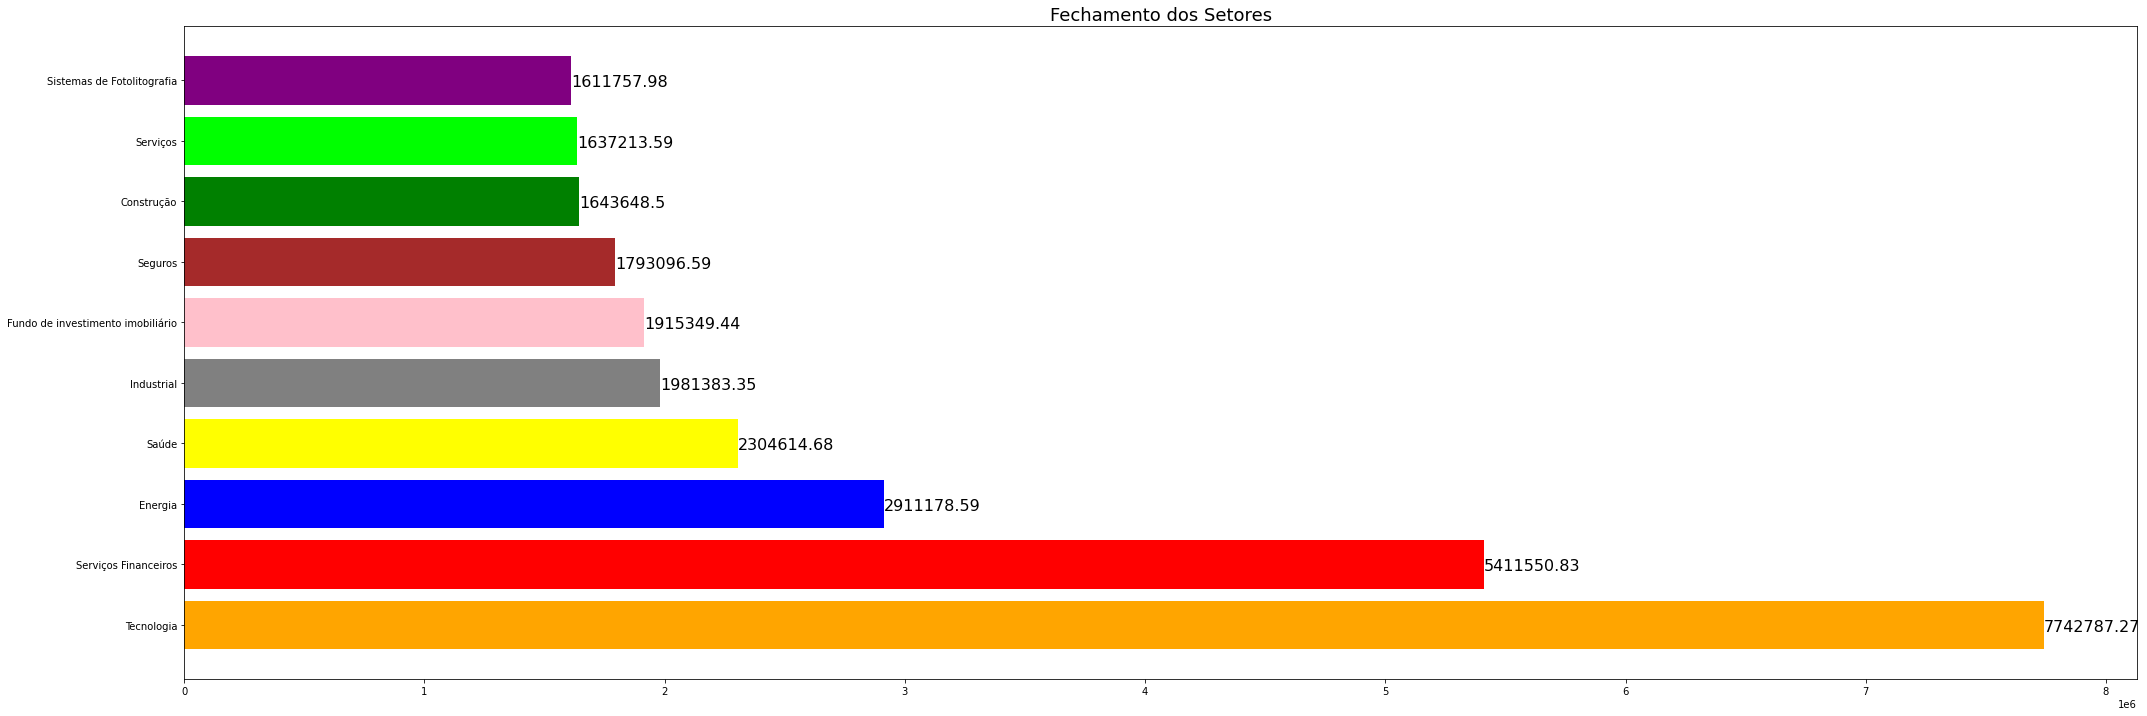

In [26]:
plot_coluna("Fechamento")

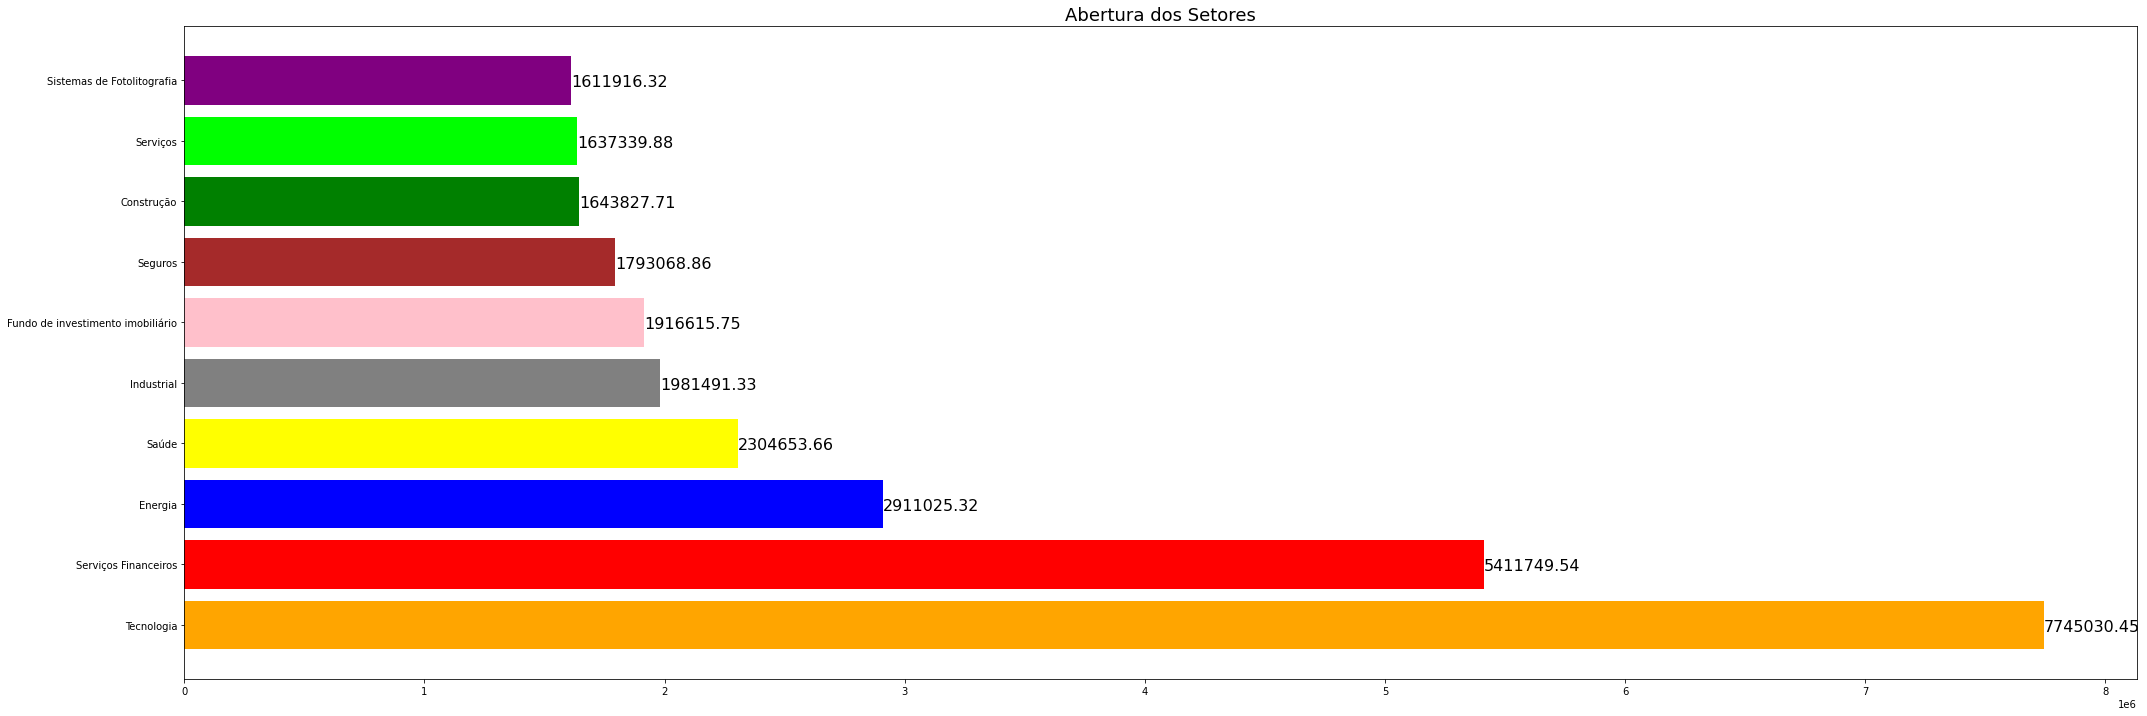

In [27]:
plot_coluna("Abertura")

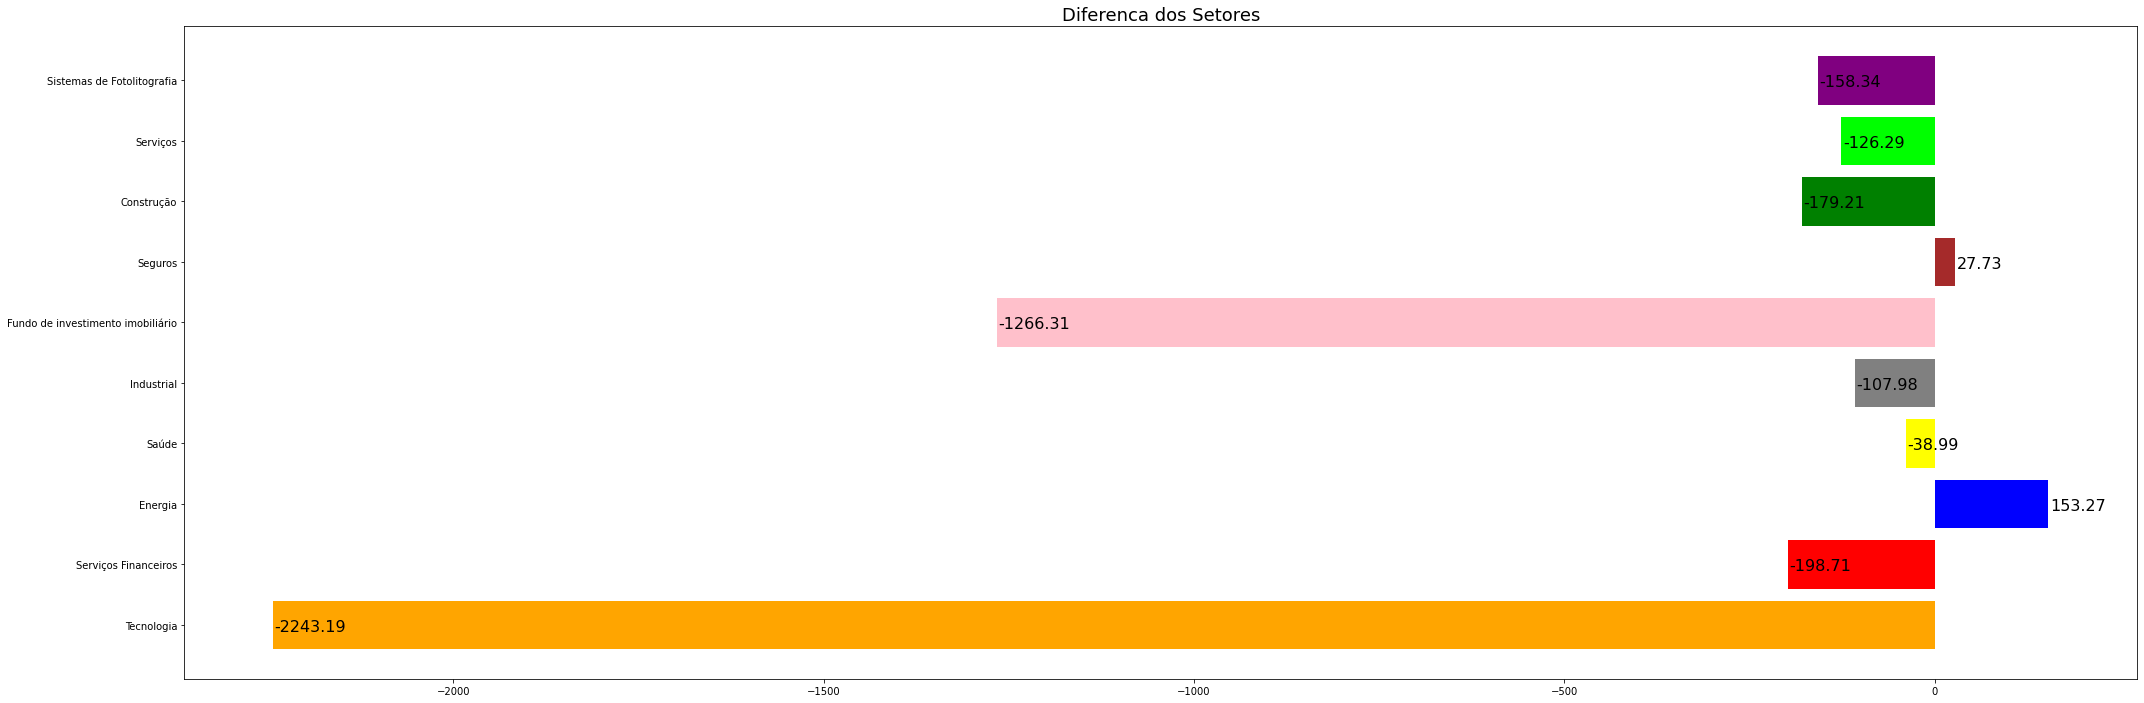

In [28]:
plot_coluna("Diferenca")

In [29]:
ticker_maior_fechamento=spark.sql("select distinct(Ticker),Setor from xd join dfx on xd.Codigo=dfx.Ticker where Setor="+"'"+str(fechamento_analise['Setor'][0])+"'")

In [30]:
ticker_maior_fechamento.show(10,False)


+---------+----------+
|Ticker   |Setor     |
+---------+----------+
|AVGO34.SA|Tecnologia|
|F1SL34.SA|Tecnologia|
|S1PL34.SA|Tecnologia|
|C1NS34.SA|Tecnologia|
|S1TX34.SA|Tecnologia|
|B2MB34.SA|Tecnologia|
|A2VL34.SA|Tecnologia|
|T1WL34.SA|Tecnologia|
|INTU34.SA|Tecnologia|
|J1NP34.SA|Tecnologia|
+---------+----------+
only showing top 10 rows



In [31]:
tickers_melhor_setor=ticker_maior_fechamento.to_pandas_on_spark()
tickers_melhor_setor_graphs=ticker_maior_fechamento.toPandas()


spark-3.3.0-bin-hadoop2/python/pyspark/sql/dataframe.py:3315: FutureWarning:

DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.



In [32]:
tickers_melhor_setor_graphs['Ticker']

0     AVGO34.SA
1     F1SL34.SA
2     S1PL34.SA
3     C1NS34.SA
4     S1TX34.SA
        ...    
67    ATVI34.SA
68    BIDU34.SA
69    G1RM34.SA
70    S1NP34.SA
71    T1OW34.SA
Name: Ticker, Length: 72, dtype: object

In [33]:
ticket_list2=list((tickers_melhor_setor_graphs['Ticker']).iloc[0:10])
df2 = yf.download(ticket_list2,period="2y",group_by="ticker");

[*********************100%***********************]  10 of 10 completed


#Análise Exploratória

In [34]:
new_df2=df2.stack(1).reset_index().rename(columns={'level_1':'Ticker'})
new_dfx2 = pd.DataFrame(new_df)
dfx2=new_dfx.to_spark()
dfx2.show()

spark-3.3.0-bin-hadoop2/python/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning:

If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.



+-------------------+---------+---------+------------------+---------+------------------+------------------+------------------+------------+-------+
|               Date|   Ticker|Adj Close|             Close|Dividends|              High|               Low|              Open|Stock Splits| Volume|
+-------------------+---------+---------+------------------+---------+------------------+------------------+------------------+------------+-------+
|2020-11-03 00:00:00|A1AP34.SA|     null| 53.43976593017578|      0.0|53.872672064652214| 53.43976593017578| 53.45900661057301|         0.0|   54.0|
|2020-11-03 00:00:00|A1BB34.SA|     null|34.503482818603516|      0.0| 34.81645919444922| 34.42760756510685| 34.42760756510685|         0.0|  583.0|
|2020-11-03 00:00:00|A1BM34.SA|     null|             373.5|      0.0|             373.5| 372.6400146484375|372.67999267578125|         0.0|  100.0|
|2020-11-03 00:00:00|A1CR34.SA|     null| 55.62111282348633|      0.0| 55.62111282348633| 55.6211128234863

In [35]:
dfx2.createOrReplaceTempView("dfx2")

In [36]:
analise_ticket_exploratoria_query=spark.sql("select Ticker, round(Sum(`Adj Close`),2) as Adj_Close,round(Sum(Dividends),2) as Dividends,round(Sum(High),2) as High,round(Sum(Low),2) as Low,round(Sum(Open),2) as Open,round(Sum(`Stock Splits`),2) as Stock_Splits,round(Sum(Volume),2) as Volume from dfx2 group by Ticker")

In [37]:
analise_ticket_exploratoria_query.show(10,False)

+---------+---------+---------+---------+---------+---------+------------+-----------+
|Ticker   |Adj_Close|Dividends|High     |Low      |Open     |Stock_Splits|Volume     |
+---------+---------+---------+---------+---------+---------+------------+-----------+
|ABTT34.SA|null     |3.01     |76048.26 |75202.13 |75662.96 |0.0         |701438.0   |
|S1MF34.SA|null     |3.56     |16429.69 |16401.47 |16413.73 |0.0         |53040.0    |
|SLBC34.SA|null     |1.5      |66257.68 |66216.16 |66241.63 |0.0         |35034.0    |
|THGI34.SA|null     |11.42    |168818.7 |168802.03|168806.33|0.0         |913.0      |
|A1MX34.SA|null     |2.2      |21806.43 |21643.87 |21711.09 |0.0         |337492.0   |
|AVGO34.SA|null     |3.52     |37214.15 |36508.21 |36903.45 |0.0         |3352001.0  |
|ABUD34.SA|null     |1.49     |26445.11 |26184.97 |26318.43 |0.0         |2196812.0  |
|CRIP34.SA|null     |0.0      |78480.1  |77015.41 |77866.39 |0.0         |228929.0   |
|PEPB34.SA|null     |3.05     |27138.43 |26

In [38]:
analise_ticket_exploratoria=analise_ticket_exploratoria_query.to_pandas_on_spark()

spark-3.3.0-bin-hadoop2/python/pyspark/sql/dataframe.py:3315: FutureWarning:

DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.



In [39]:
def analisar_coluna(coluna_nome): #criamos uma classefuncao para analisar cada coluna e reduzir o codigo
        coluna = coluna_nome
        media = analise_ticket_exploratoria[coluna_nome].mean()
        mediana = analise_ticket_exploratoria[coluna_nome].median()
        primeiro_quartil = analise_ticket_exploratoria[coluna_nome].quantile(.25)
        segundo_quartil = analise_ticket_exploratoria[coluna_nome].quantile(.50)
        terceiro_quartil = analise_ticket_exploratoria[coluna_nome].quantile(.75)
        quarto_quartil = analise_ticket_exploratoria[coluna_nome].quantile(1.0)
        desvio_padrao = analise_ticket_exploratoria[coluna_nome].std()
        maximo = analise_ticket_exploratoria[coluna_nome].max()
        minimo = analise_ticket_exploratoria[coluna_nome].min()
        Analise = (coluna, media, mediana, primeiro_quartil, segundo_quartil, terceiro_quartil, quarto_quartil, desvio_padrao, maximo, minimo)
        return Analise

In [40]:
analise_adj_close=analisar_coluna("Adj_Close")
analise_dividends=analisar_coluna("Dividends")
analise_low=analisar_coluna("Low")
analise_open=analisar_coluna("Open")
analise_stock_splits=analisar_coluna("Stock_Splits")
analise_volume=analisar_coluna("Volume")

In [41]:
data = [(analise_adj_close), (analise_dividends), (analise_low),(analise_open),(analise_stock_splits),(analise_volume)]

columns = StructType([ \
StructField("coluna",StringType(),True), \
StructField("media",StringType(),True), \
StructField("mediana",StringType(),True), \
StructField("primeiro_quartil",StringType(),True), \
StructField("segundo_quartil", StringType(), True), \
StructField("terceiro_quartil", StringType(), True), \
StructField("quarto_quartil", StringType(), True), \
StructField("desvio_padrao", StringType(), True), \
StructField("maximo", StringType(), True), \
StructField("minimo", StringType(), True) \
  ])

In [42]:
spark2 = SparkSession.builder.master("local[*]").appName("AnalisExploratória").getOrCreate()
sdf = spark2.createDataFrame(data=data,schema = columns)

In [43]:
sdf.createOrReplaceTempView("sdf")

In [44]:
analise_exploratoria_query=spark.sql("select coluna as coluna, round(media,2) as media,mediana,primeiro_quartil,segundo_quartil,terceiro_quartil,round(cast(quarto_quartil as decimal),2) as quarto_quartil,round(desvio_padrao,2) as desvio_padrao,maximo,minimo from sdf")

In [45]:
analise_exploratoria_query.show(10,False)

+------------+----------+--------+----------------+---------------+----------------+--------------+-------------+------------+--------+
|coluna      |media     |mediana |primeiro_quartil|segundo_quartil|terceiro_quartil|quarto_quartil|desvio_padrao|maximo      |minimo  |
+------------+----------+--------+----------------+---------------+----------------+--------------+-------------+------------+--------+
|Adj_Close   |NaN       |NaN     |NaN             |NaN            |NaN             |null          |NaN          |NaN         |NaN     |
|Dividends   |8.74      |3.93    |0.0             |3.93           |10.33           |664           |30.22        |664.25      |0.0     |
|Low         |108305.8  |90298.01|28458.37        |90298.01       |152464.06       |1601787       |116190.01    |1601787.07  |-6581.19|
|Open        |108639.24 |90657.58|28697.55        |90657.58       |152464.06       |1611916       |116655.22    |1611916.32  |-6587.37|
|Stock_Splits|0.61      |0.0     |0.0           

# Predicao

In [46]:
def f_regressao_polinomial(x, y):
  modelo = np.poly1d(np.polyfit(x, y, 3))
  return modelo

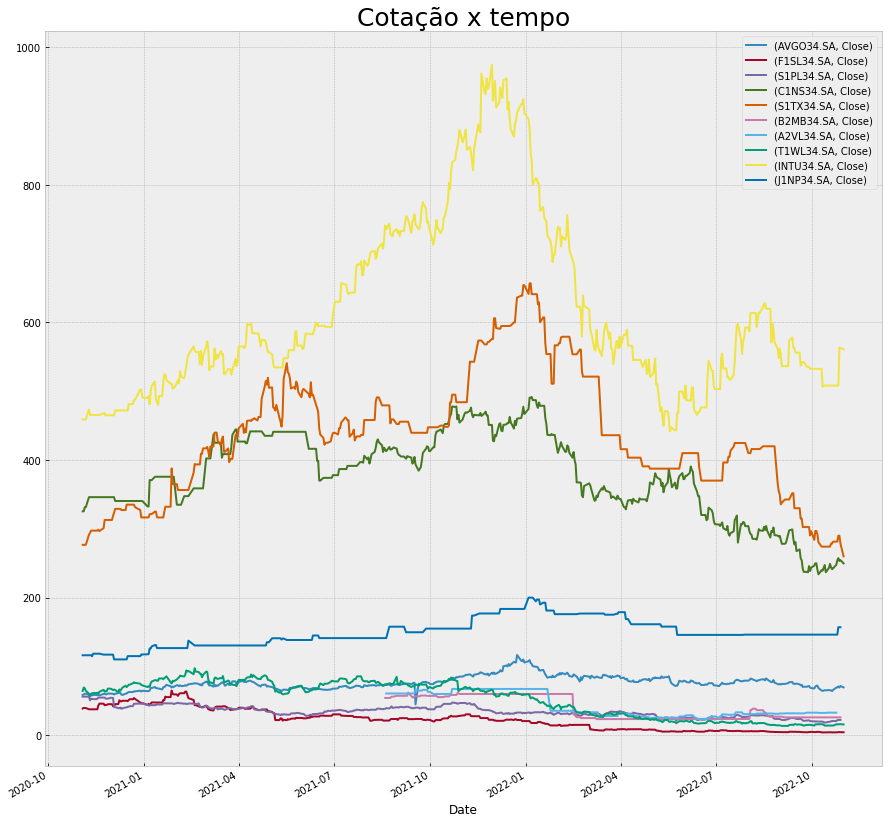

In [90]:
for acao in ticket_list2:
  serie = df2[acao, 'Close']
  serie.plot()

plt.title("Cotação x tempo", fontsize = 25)
# Legendas
#plt.legend(loc='lower left')
#plt.legend(loc=2)
plt.legend(loc='best')
plt.rcParams["figure.figsize"] = (15,15)


In [48]:
plt.style.use('bmh')

In [49]:
df2_pred_list = df2[ticket_list2]


In [50]:
ticket_list2

['AVGO34.SA',
 'F1SL34.SA',
 'S1PL34.SA',
 'C1NS34.SA',
 'S1TX34.SA',
 'B2MB34.SA',
 'A2VL34.SA',
 'T1WL34.SA',
 'INTU34.SA',
 'J1NP34.SA']

In [51]:
len(ticket_list2)

10

In [52]:
df2_pred_list[ticket_list2[0]]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-11-03,58.099998,58.599998,57.830002,58.599998,56.038128,310
2020-11-04,59.049999,59.299999,59.049999,59.299999,56.707527,296
2020-11-05,60.049999,60.470001,60.049999,60.369999,57.730747,5016
2020-11-06,60.369999,60.369999,60.369999,60.369999,57.730747,0
2020-11-09,57.860001,59.750000,57.860001,58.820000,56.248508,5235
...,...,...,...,...,...,...
2022-10-25,69.989998,70.290001,69.489998,69.489998,69.489998,4069
2022-10-26,71.449997,71.449997,70.629997,70.919998,70.919998,2262
2022-10-27,69.349998,69.419998,69.230003,69.330002,69.330002,2110


In [53]:
df2_pred_close_list = []

In [54]:
for i in range(len(ticket_list2)):
  df2_pred_close_list.append(df2_pred_list[ticket_list2[i]][["Close"]])

In [55]:
df2_pred_close_list

[                Close
 Date                 
 2020-11-03  58.599998
 2020-11-04  59.299999
 2020-11-05  60.369999
 2020-11-06  60.369999
 2020-11-09  58.820000
 ...               ...
 2022-10-25  69.489998
 2022-10-26  70.919998
 2022-10-27  69.330002
 2022-10-28  71.690002
 2022-10-31  69.500000
 
 [495 rows x 1 columns],                 Close
 Date                 
 2020-11-03  38.930000
 2020-11-04  39.700001
 2020-11-05  39.700001
 2020-11-06  39.599998
 2020-11-09  37.750000
 ...               ...
 2022-10-25   4.240000
 2022-10-26   4.590000
 2022-10-27   4.580000
 2022-10-28   4.580000
 2022-10-31   4.390000
 
 [495 rows x 1 columns],                 Close
 Date                 
 2020-11-03  56.139999
 2020-11-04  56.139999
 2020-11-05  56.139999
 2020-11-06  56.139999
 2020-11-09  56.139999
 ...               ...
 2022-10-25  21.910000
 2022-10-26  22.280001
 2022-10-27  22.280001
 2022-10-28  22.280001
 2022-10-31        NaN
 
 [495 rows x 1 columns],                  Close
 

In [56]:
df2_pred_close_list[3]

,Close
Date,
2020-11-03,325.410004
2020-11-04,325.410004
2020-11-05,331.489990
2020-11-06,331.489990
2020-11-09,346.019989
...,...
2022-10-25,254.210007
2022-10-26,257.429993
2022-10-27,253.250000


In [57]:
x_list = []

In [58]:
y_list = []

In [59]:
x_treino_list = []

In [60]:
x_test_list = []

In [61]:
y_treino_list = []

In [62]:
y_test_list = []

In [63]:
model_list = []

In [64]:
x_futuro_list = []

In [65]:
dias_futuros = 30

In [66]:
for i in range(len(ticket_list2)): #trocando valores NaN pela media
  df2_pred_close_list[i][df2_pred_close_list[i]['Close'].isna()] = df2_pred_close_list[i].mean()

In [67]:
total = (sum([df2_pred_close_list[0], df2_pred_close_list[1],df2_pred_close_list[2],df2_pred_close_list[3],df2_pred_close_list[4],df2_pred_close_list[5],df2_pred_close_list[6],df2_pred_close_list[7],df2_pred_close_list[8],df2_pred_close_list[9]]))

In [68]:
total

,Close
Date,
2020-11-03,1477.203543
2020-11-04,1483.693548
2020-11-05,1489.693533
2020-11-06,1485.933527
2020-11-09,1522.063517
...,...
2022-10-25,1370.155307
2022-10-26,1395.205294
2022-10-27,1444.225302


In [69]:
df2_pred_close_list[3]

,Close
Date,
2020-11-03,325.410004
2020-11-04,325.410004
2020-11-05,331.489990
2020-11-06,331.489990
2020-11-09,346.019989
...,...
2022-10-25,254.210007
2022-10-26,257.429993
2022-10-27,253.250000


In [70]:
df2_pred_close_list[3].mean()

Close    377.059635
dtype: float64

In [71]:
for i in range(len(ticket_list2)):
  df2_pred_close_list[i]["Predicao"] = df2_pred_close_list[i]["Close"].shift(-dias_futuros)

In [72]:
total["Predicao"] = total["Close"].shift(-dias_futuros)

In [73]:
total

,Close,Predicao
Date,,
2020-11-03,1477.203543,1568.663527
2020-11-04,1483.693548,1582.213545
2020-11-05,1489.693533,1584.883551
2020-11-06,1485.933527,1586.683546
2020-11-09,1522.063517,1600.633539
...,...,...
2022-10-25,1370.155307,NaN
2022-10-26,1395.205294,NaN
2022-10-27,1444.225302,NaN


In [74]:
df2_pred_close_list[3]

,Close,Predicao
Date,,
2020-11-03,325.410004,340.459991
2020-11-04,325.410004,340.459991
2020-11-05,331.489990,340.459991
2020-11-06,331.489990,340.459991
2020-11-09,346.019989,340.459991
...,...,...
2022-10-25,254.210007,NaN
2022-10-26,257.429993,NaN
2022-10-27,253.250000,NaN


In [75]:
len(df2_pred_close_list[3])

495

In [76]:
len(df2_pred_close_list)

10

In [77]:
df2_pred_close_list[3]

,Close,Predicao
Date,,
2020-11-03,325.410004,340.459991
2020-11-04,325.410004,340.459991
2020-11-05,331.489990,340.459991
2020-11-06,331.489990,340.459991
2020-11-09,346.019989,340.459991
...,...,...
2022-10-25,254.210007,NaN
2022-10-26,257.429993,NaN
2022-10-27,253.250000,NaN


In [78]:
total

,Close,Predicao
Date,,
2020-11-03,1477.203543,1568.663527
2020-11-04,1483.693548,1582.213545
2020-11-05,1489.693533,1584.883551
2020-11-06,1485.933527,1586.683546
2020-11-09,1522.063517,1600.633539
...,...,...
2022-10-25,1370.155307,NaN
2022-10-26,1395.205294,NaN
2022-10-27,1444.225302,NaN


In [79]:
for i in range(len(ticket_list2)):
  x_list.append(np.array(df2_pred_close_list[i].drop(["Predicao"], 1))[:-dias_futuros])
  y_list.append(np.array(df2_pred_close_list[i]["Predicao"])[:-dias_futuros])
  x_futuro_list.append(df2_pred_close_list[i].drop(["Predicao"], 1)[:-dias_futuros])
  x_futuro_list[i] = x_futuro_list[i].tail(dias_futuros)
  x_futuro_list[i] = np.array(x_futuro_list[i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



In [80]:
total_x = np.array(total.drop(["Predicao"], 1))[:-dias_futuros]
total_y = np.array(total["Predicao"])[:-dias_futuros]
total_x_futuro = total.drop(["Predicao"], 1)[:-dias_futuros]
total_x_futuro = total_x_futuro.tail(dias_futuros)
total_x_futuro = np.array(total_x_futuro)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



In [81]:
def plot_predicao(i):
  x_treino, x_test ,y_treino, y_test = train_test_split(x_list[i], y_list[i], test_size = 0.25)
  model = LinearRegression().fit(x_treino, y_treino)
  predicao = model.predict(x_futuro_list[i])
  predicoes = predicao
  valido = df2_pred_close_list[i][x_list[i].shape[0]:]
  valido["Predicoes"] = predicoes
  plt.figure(figsize = (15, 15))
  plt.title("Valor da Ação "+ticket_list2[i]+" no Período")
  plt.xlabel("Período")
  plt.ylabel("Preço de Fechamento")
  plt.plot(df2_pred_close_list[i]["Close"])
  plt.plot(valido[["Close", "Predicoes"]])
  plt.legend(["Origem", "Real", "Predicao"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

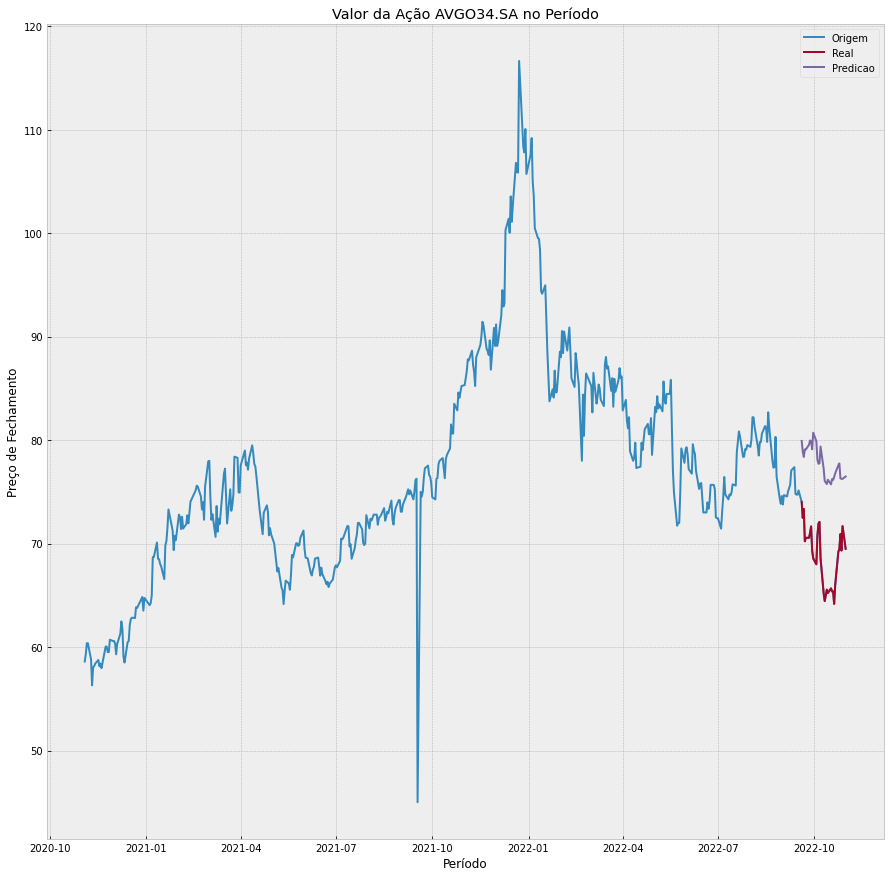

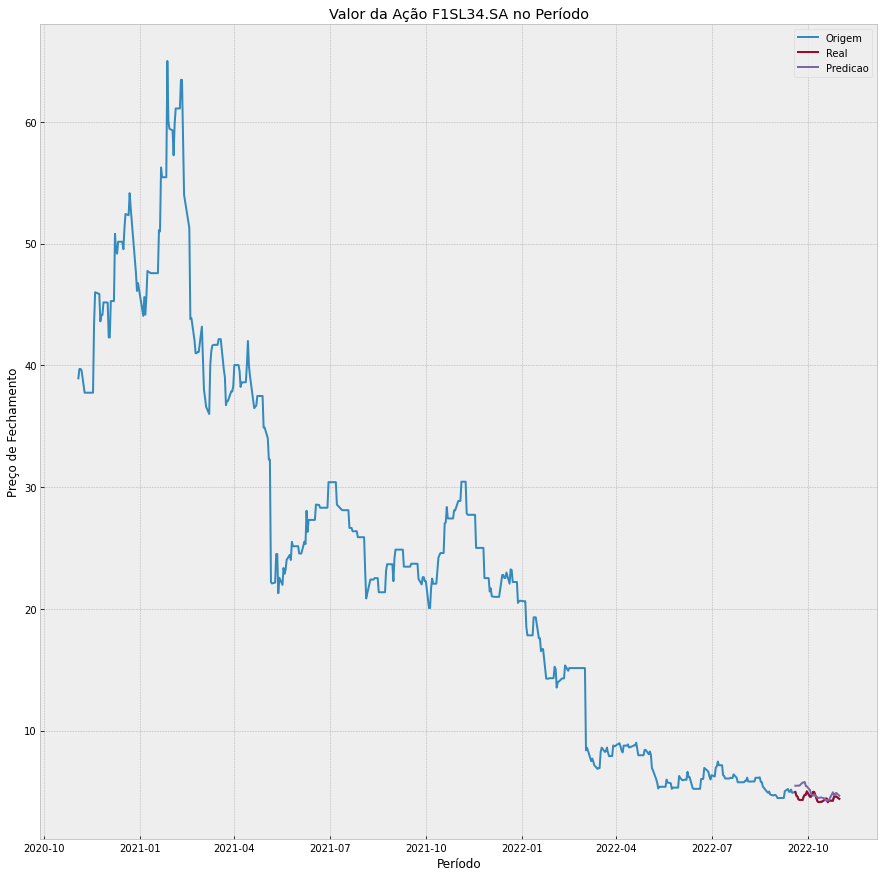

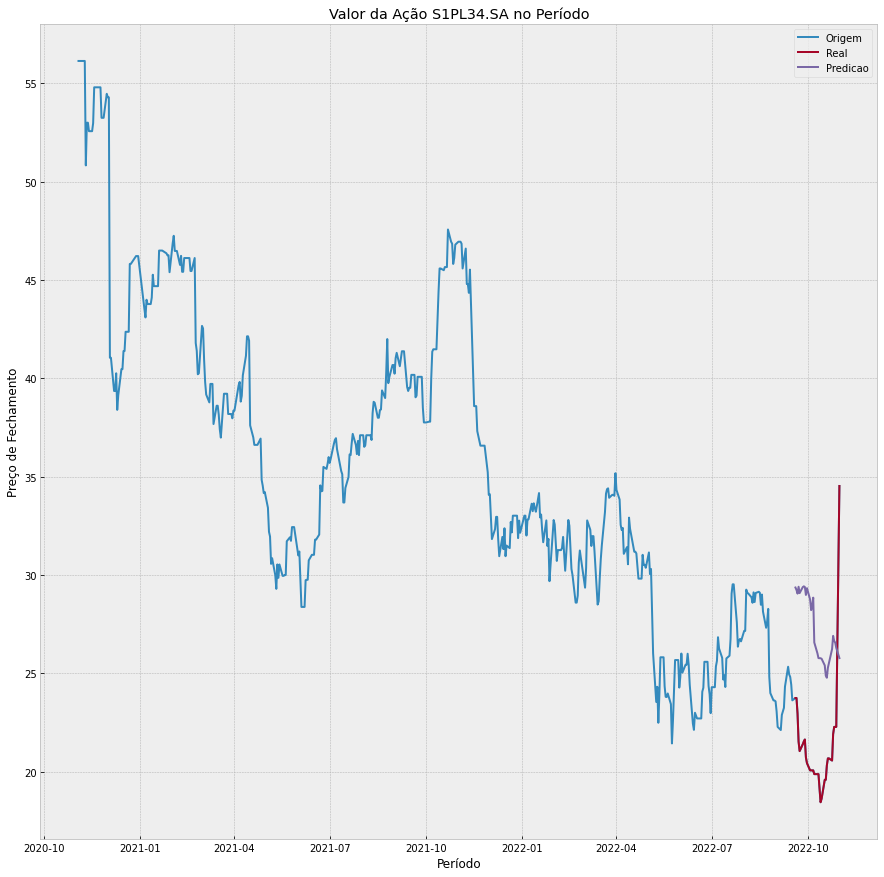

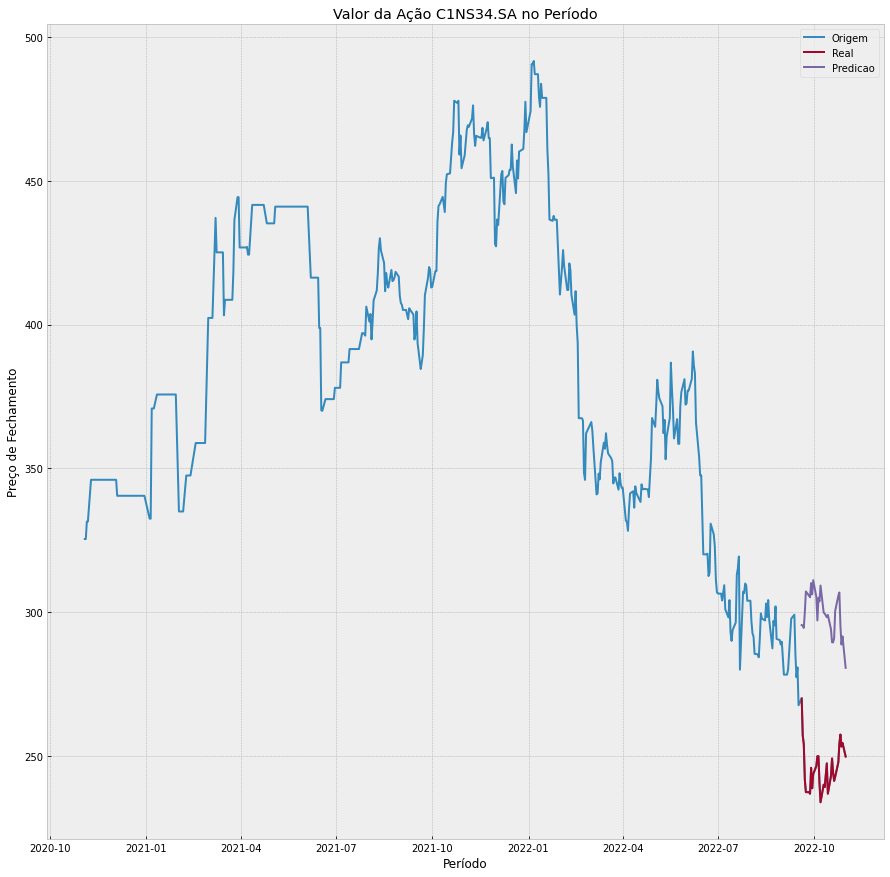

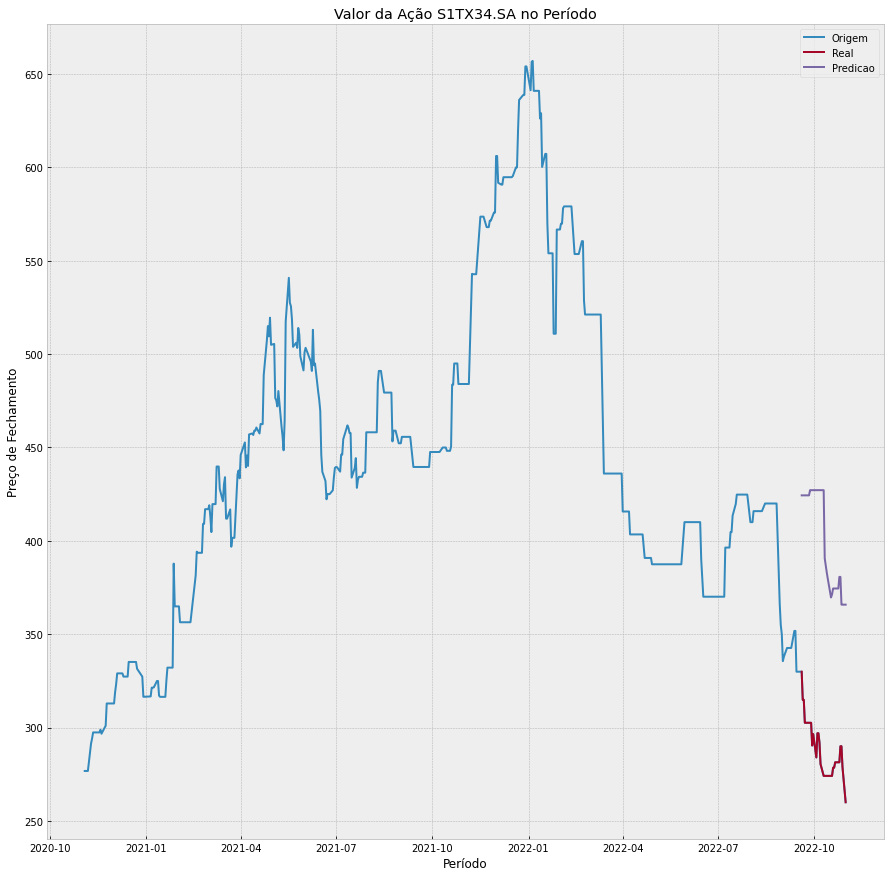

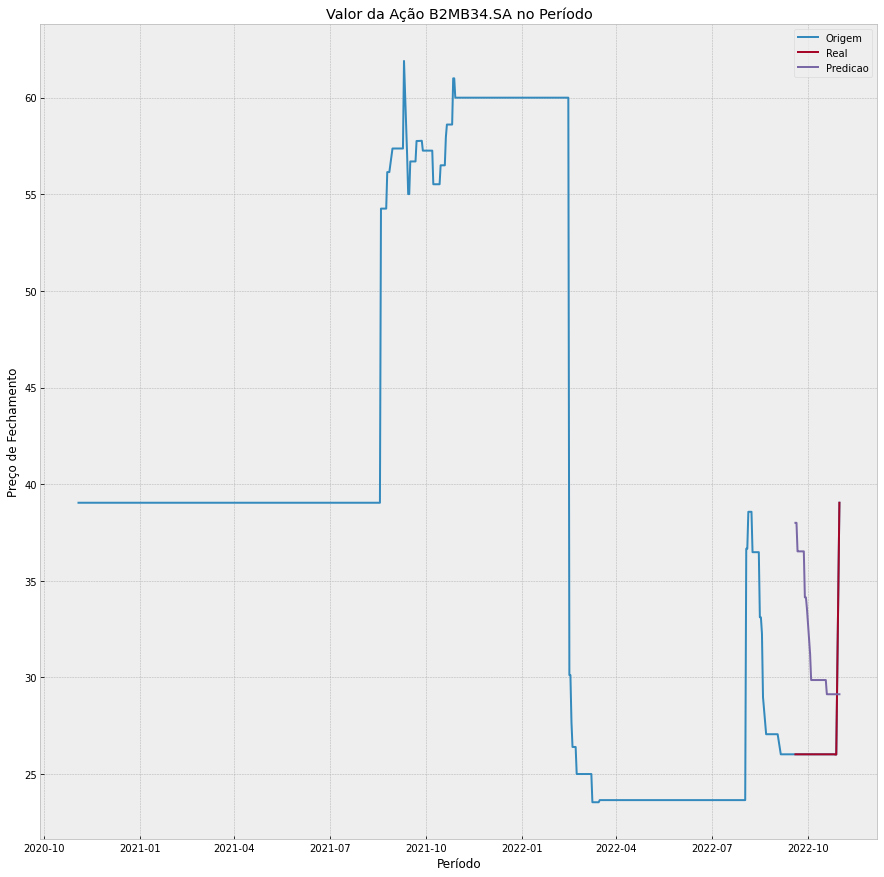

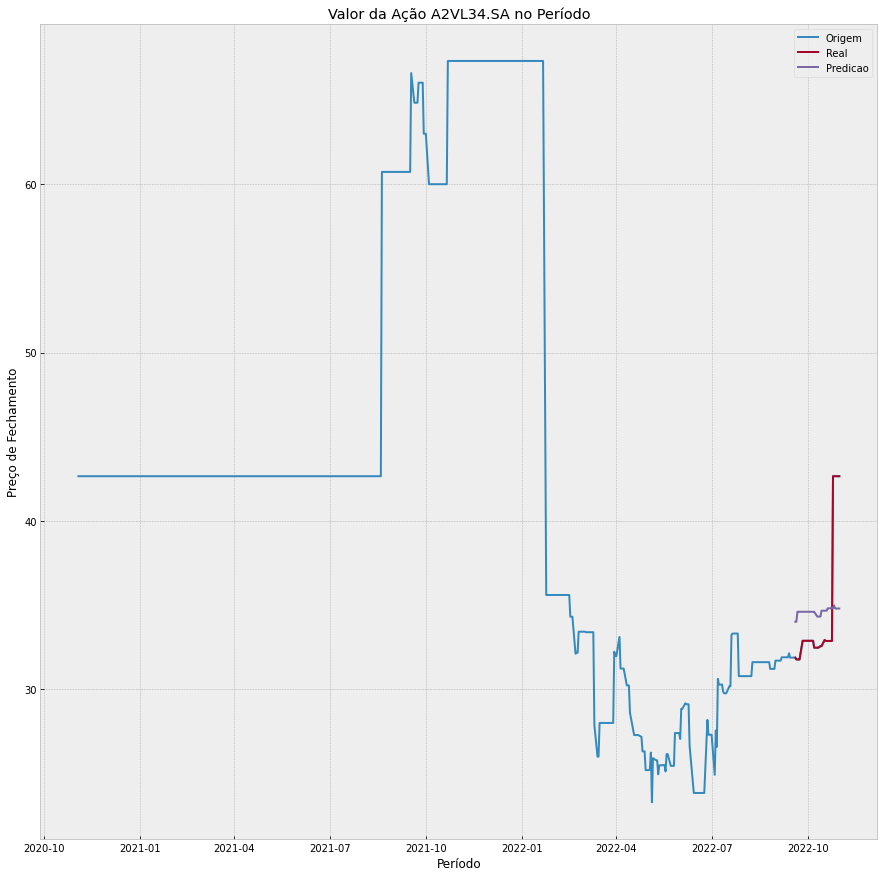

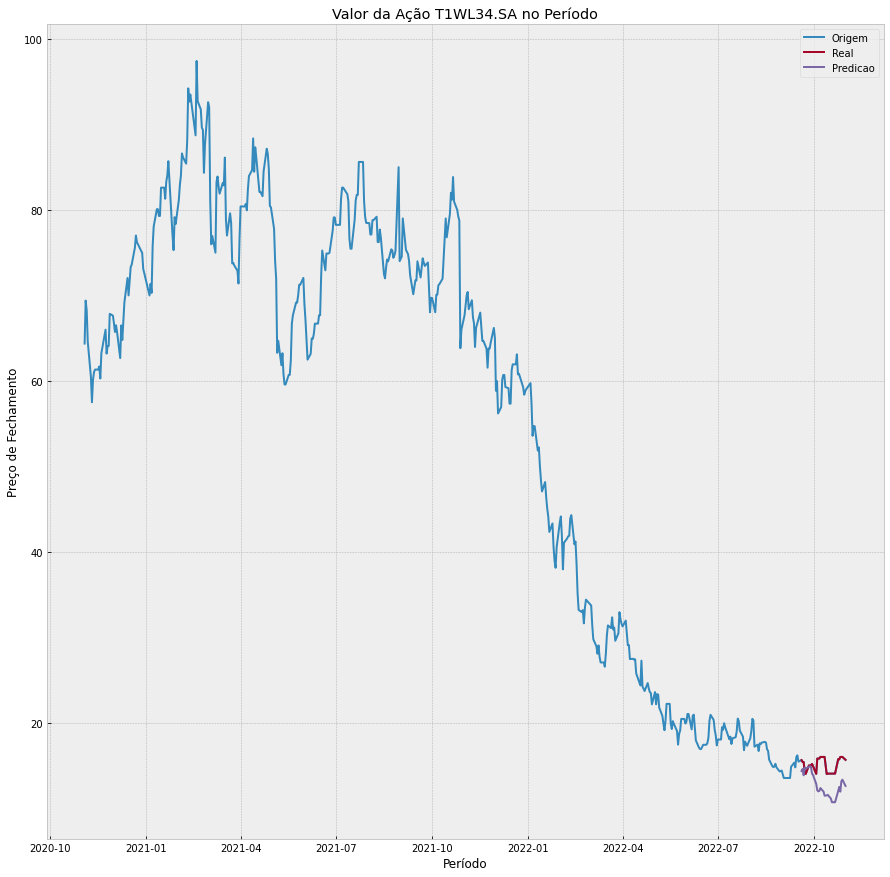

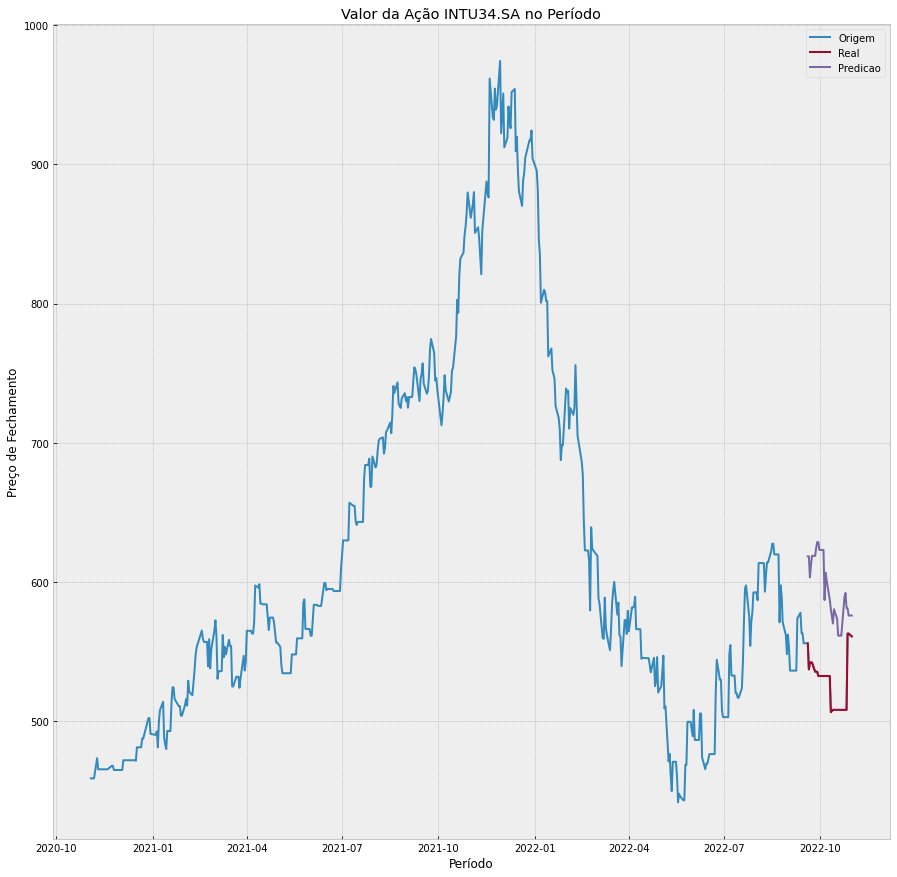

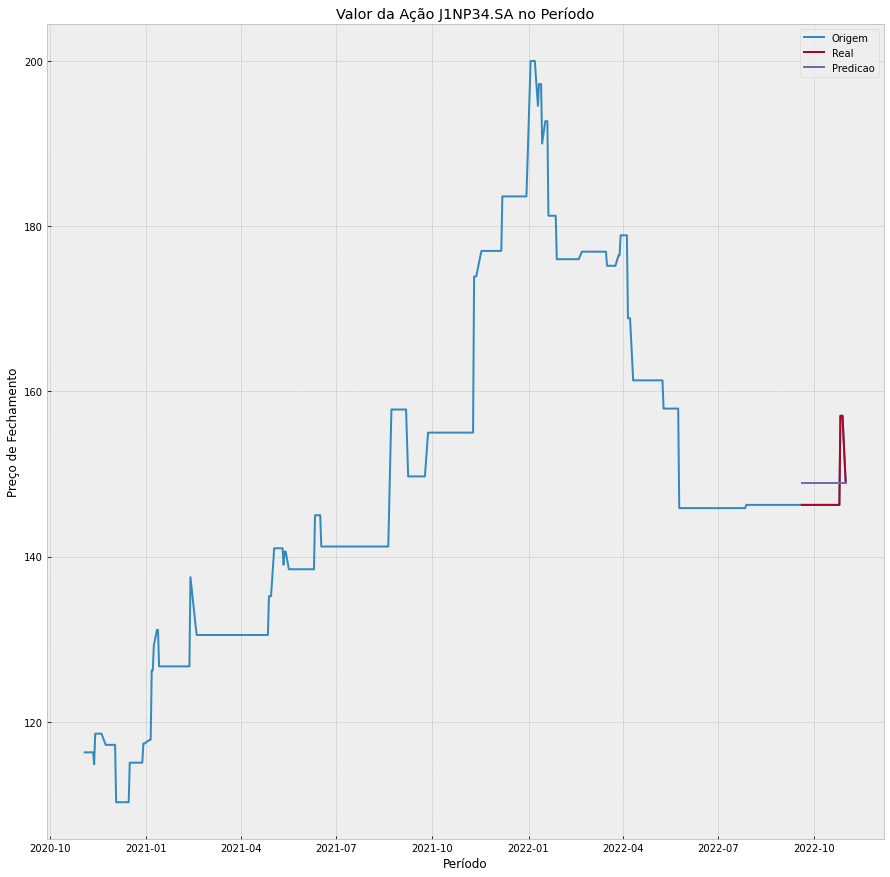

In [82]:
for i in range(len(ticket_list2)):
  plot_predicao(i)
  
  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



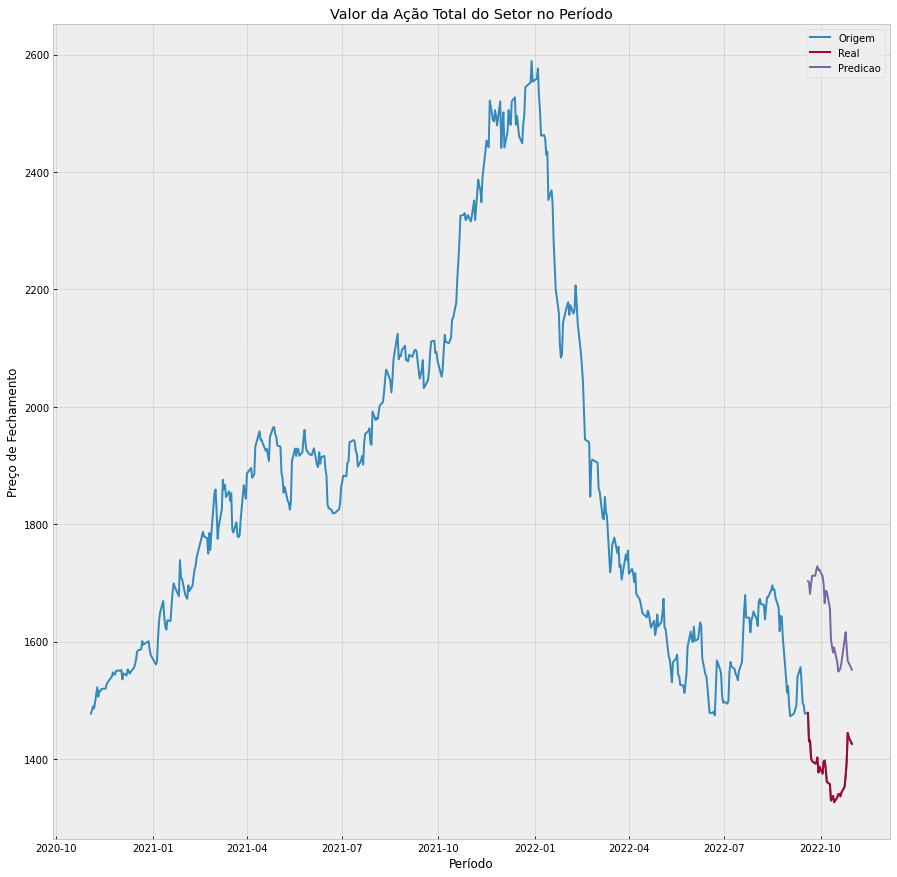

In [83]:
total_treino_x, total_test_x ,total_treino_y, total_test_y = train_test_split(total_x, total_y, test_size = 0.25)
model = LinearRegression().fit(total_treino_x, total_treino_y)
predicao = model.predict(total_x_futuro)
predicoes = predicao
valido = total[total_x.shape[0]:]
valido["Predicoes"] = predicoes
plt.figure(figsize = (15, 15))
plt.title("Valor da Ação "+"Total do Setor"+" no Período")
plt.xlabel("Período")
plt.ylabel("Preço de Fechamento")
plt.plot(total["Close"])
plt.plot(valido[["Close", "Predicoes"]])
plt.legend(["Origem", "Real", "Predicao"])

# Médias Móveis

In [84]:
def media_plot(grafico, media_movel_dias):
  media_movel_total = grafico.copy()
  max = media_movel_total["Close"].count()
  k = 0
  l = media_movel_dias
  plt.figure(figsize = (20, 20))
  for x in range(0, max, media_movel_dias):
    media_movel_total["Close"][k:l] = grafico["Close"][k:l].mean()
    k = k + media_movel_dias
    l = l + media_movel_dias
  return(plt.plot(grafico["Close"])+plt.plot(media_movel_total["Close"]))

In [85]:
media_movel_dias = 9

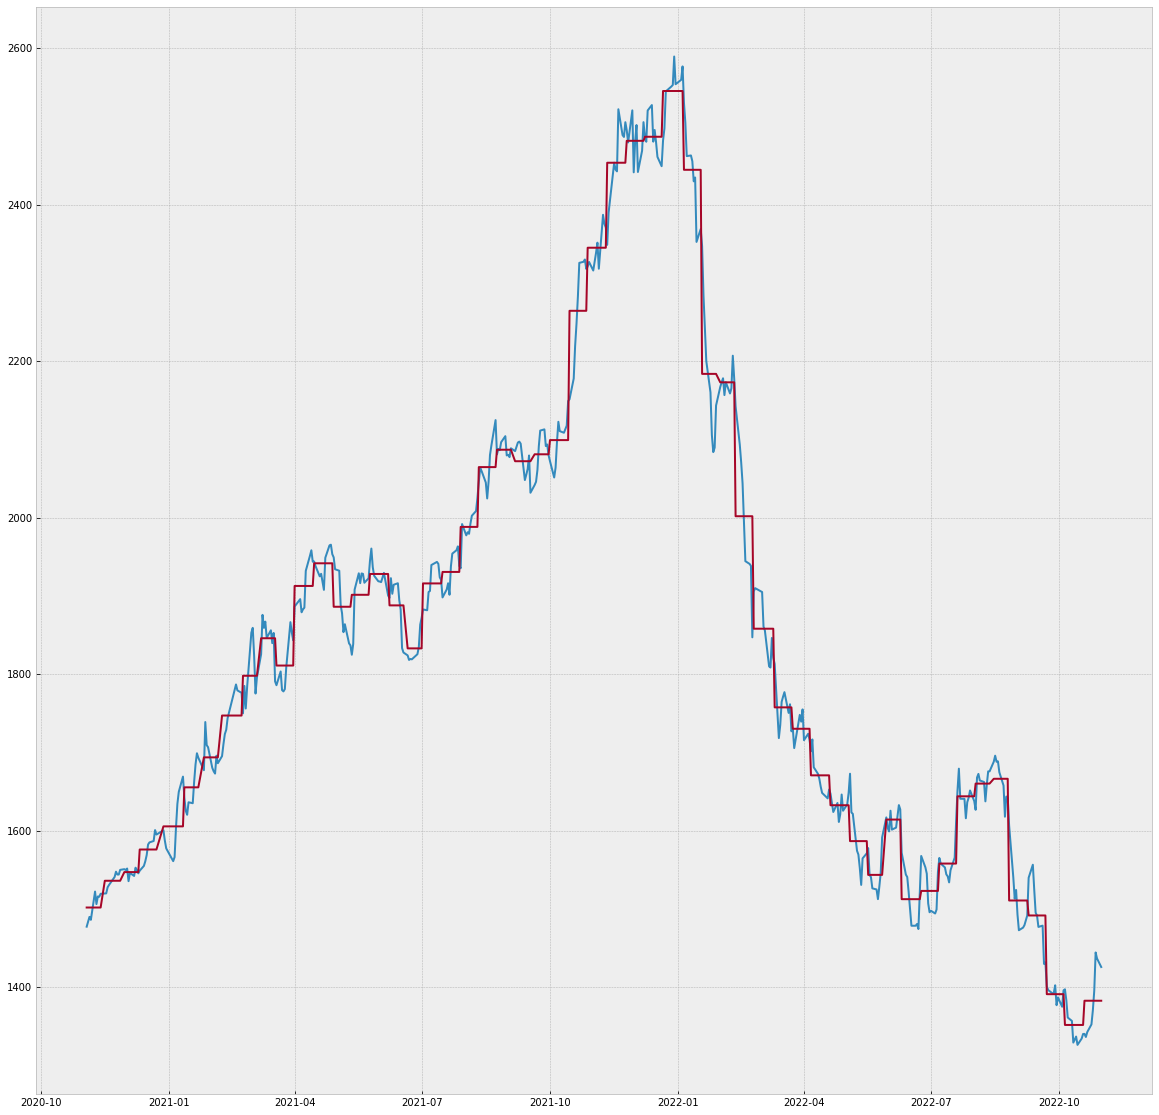

In [86]:
media_plot(total, media_movel_dias)

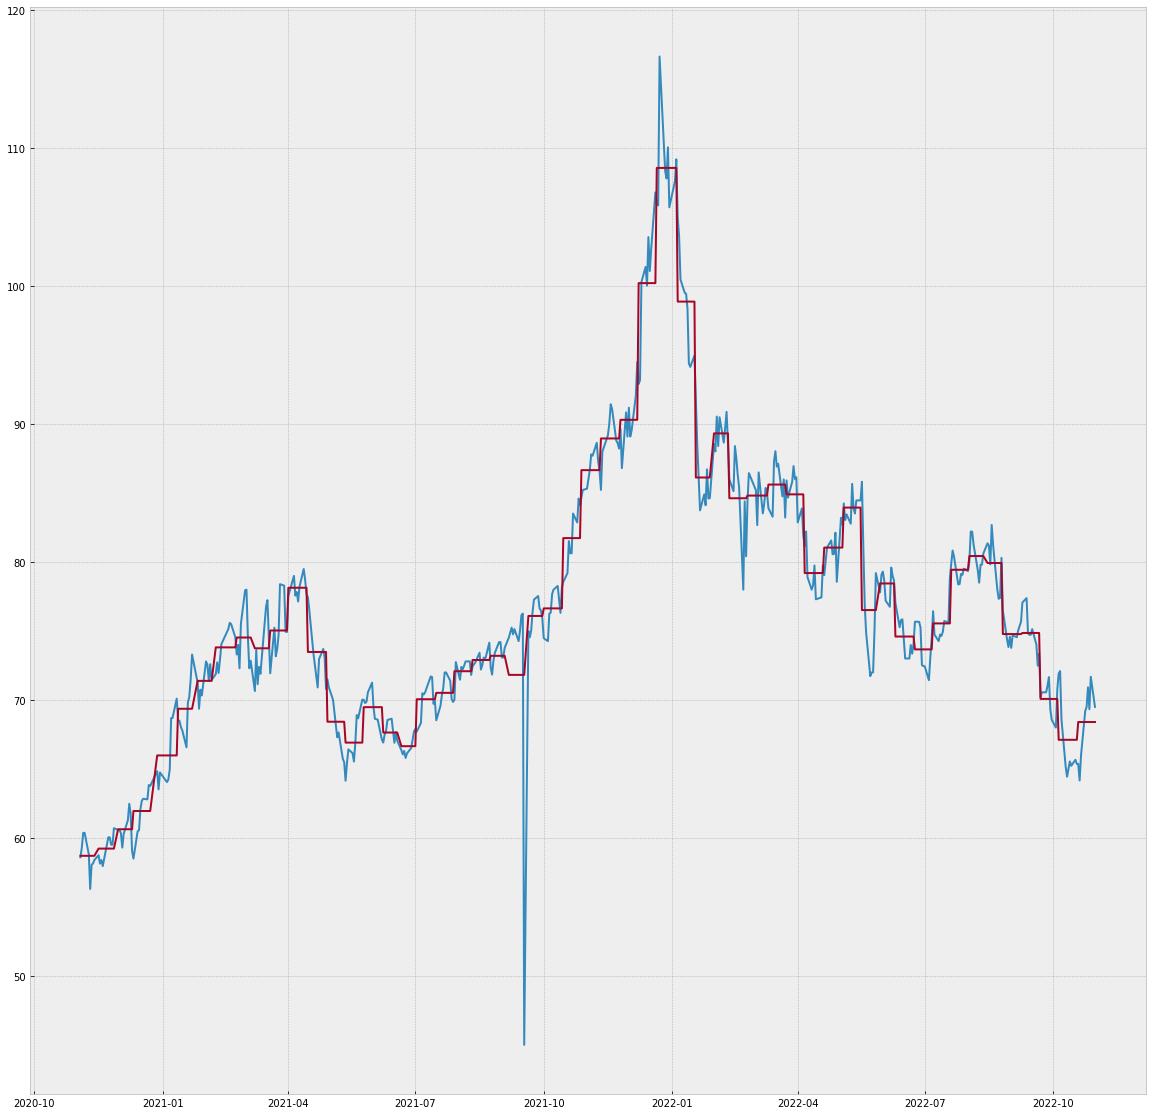

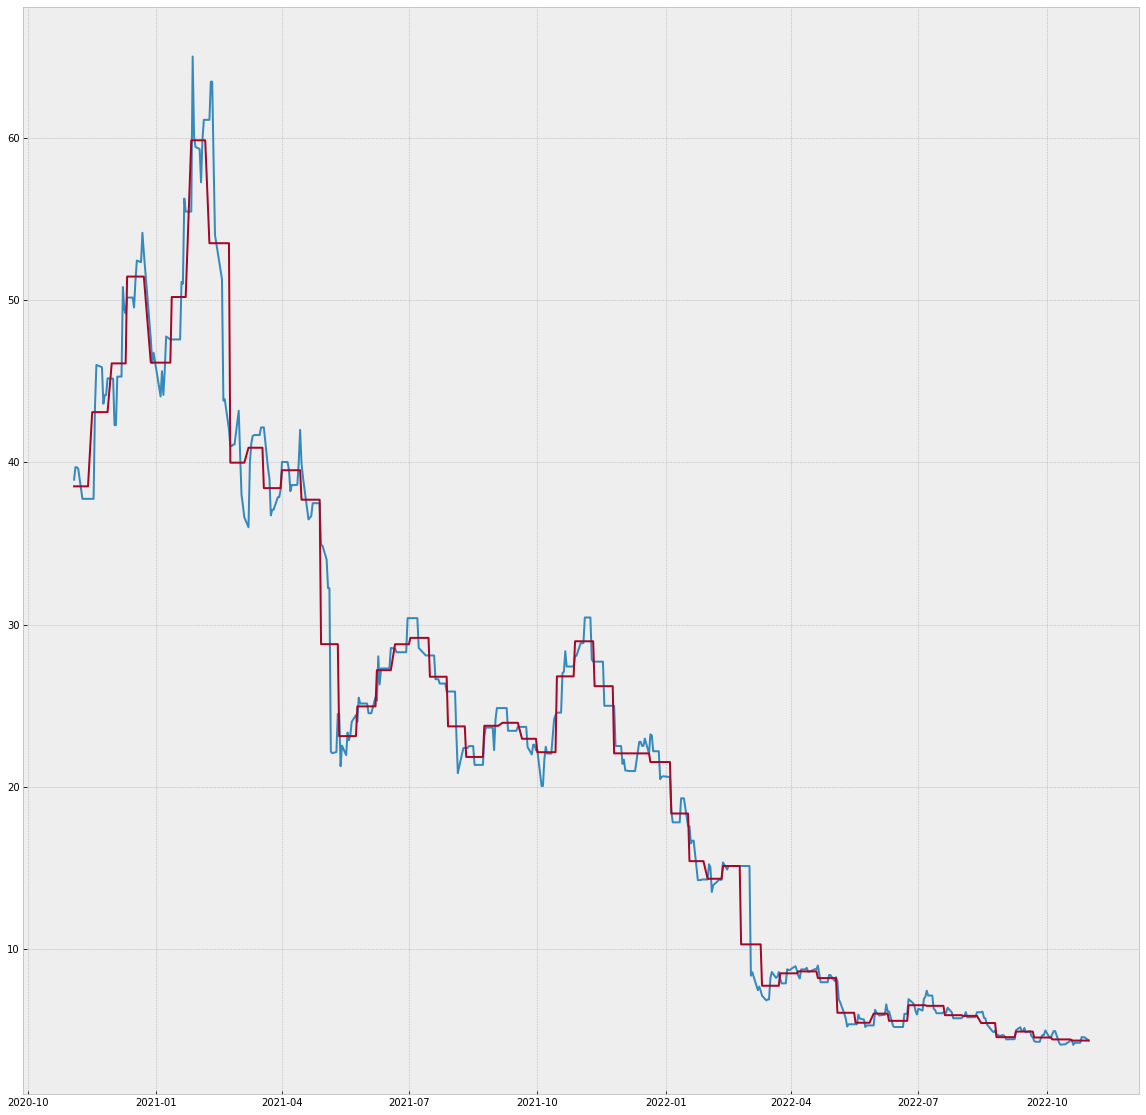

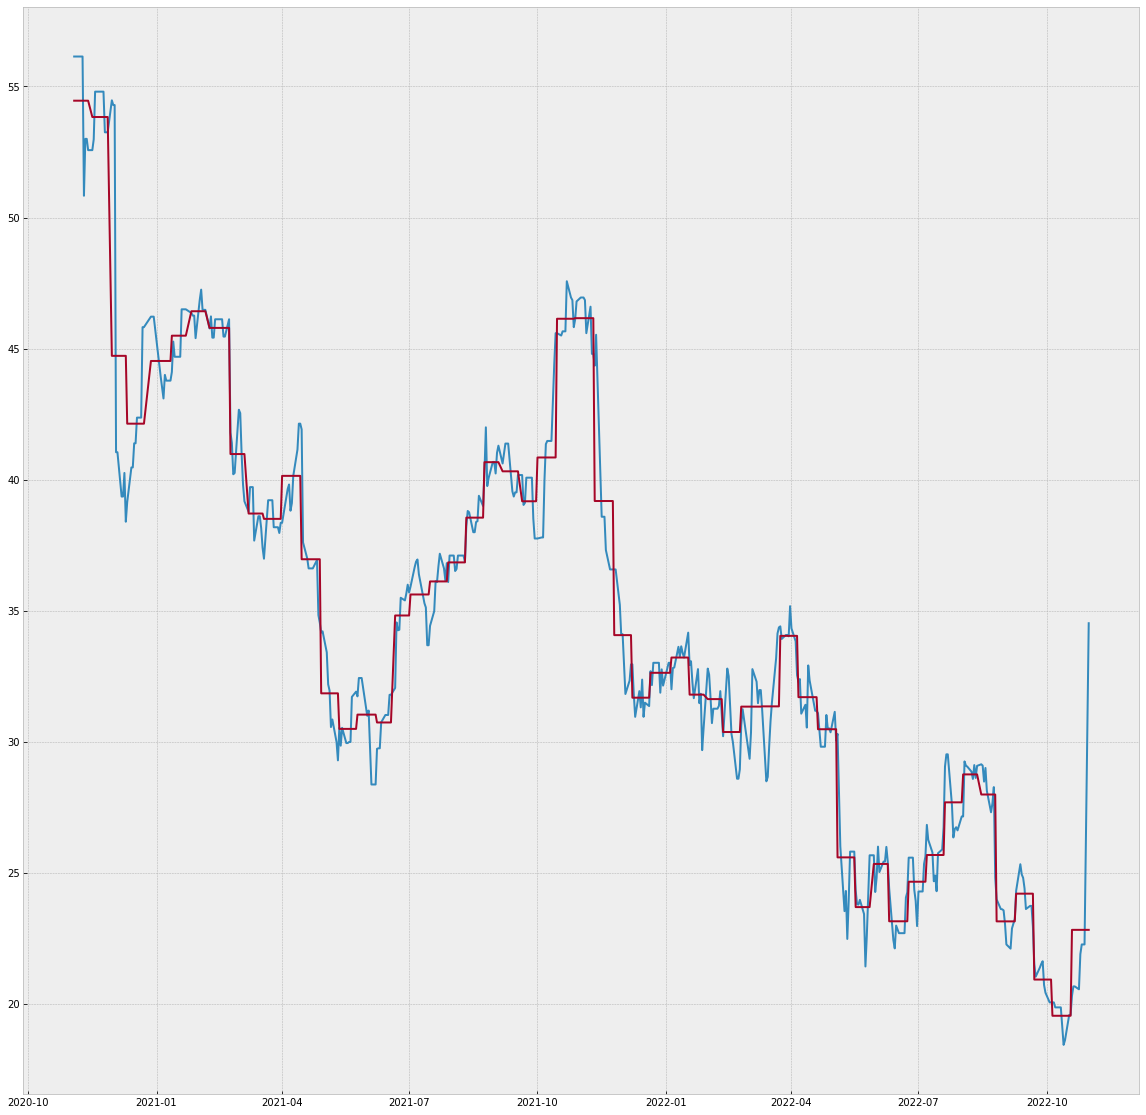

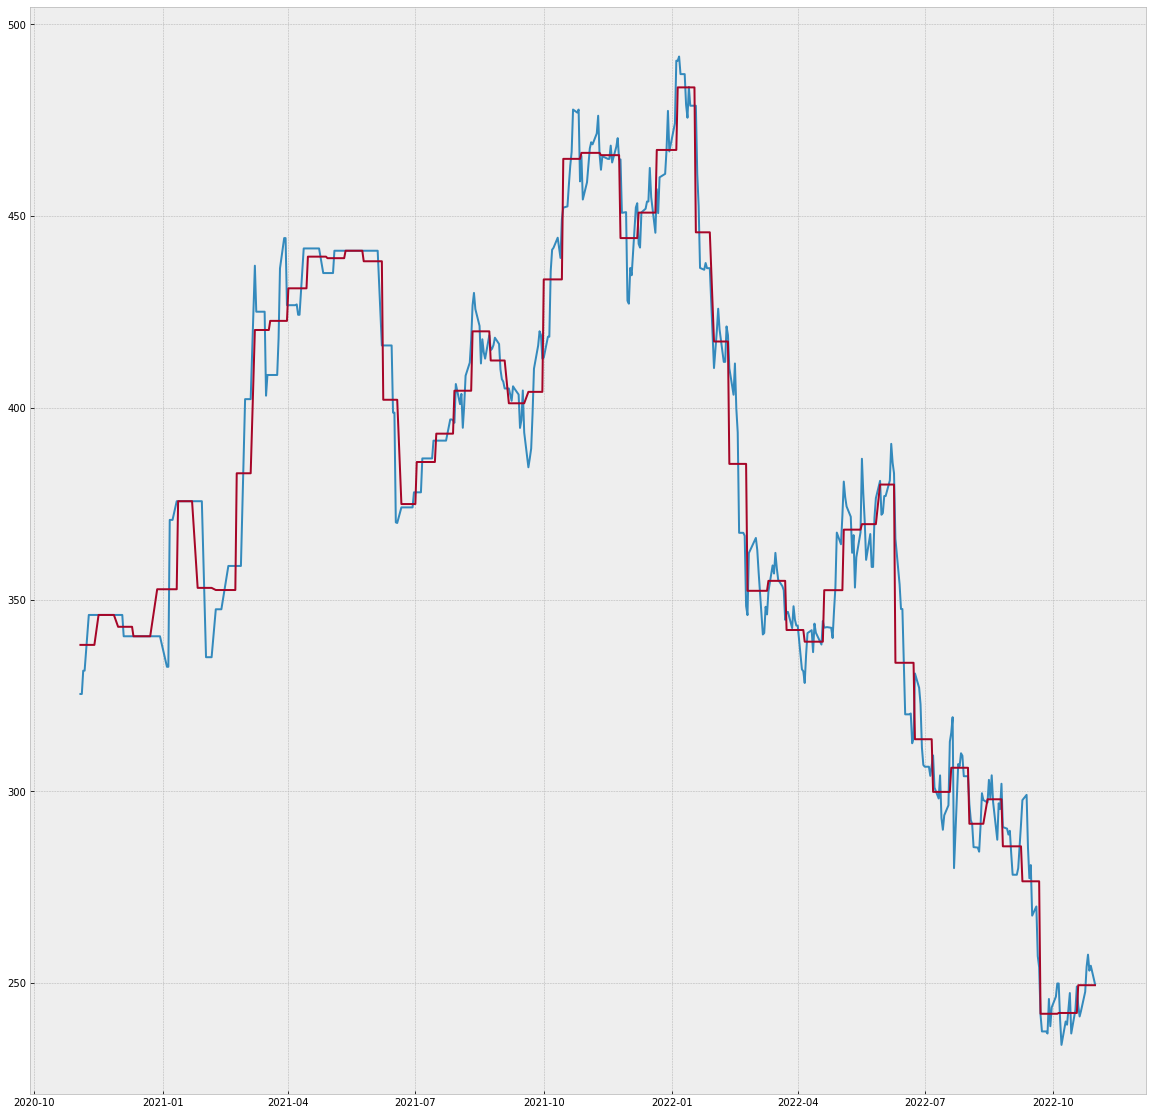

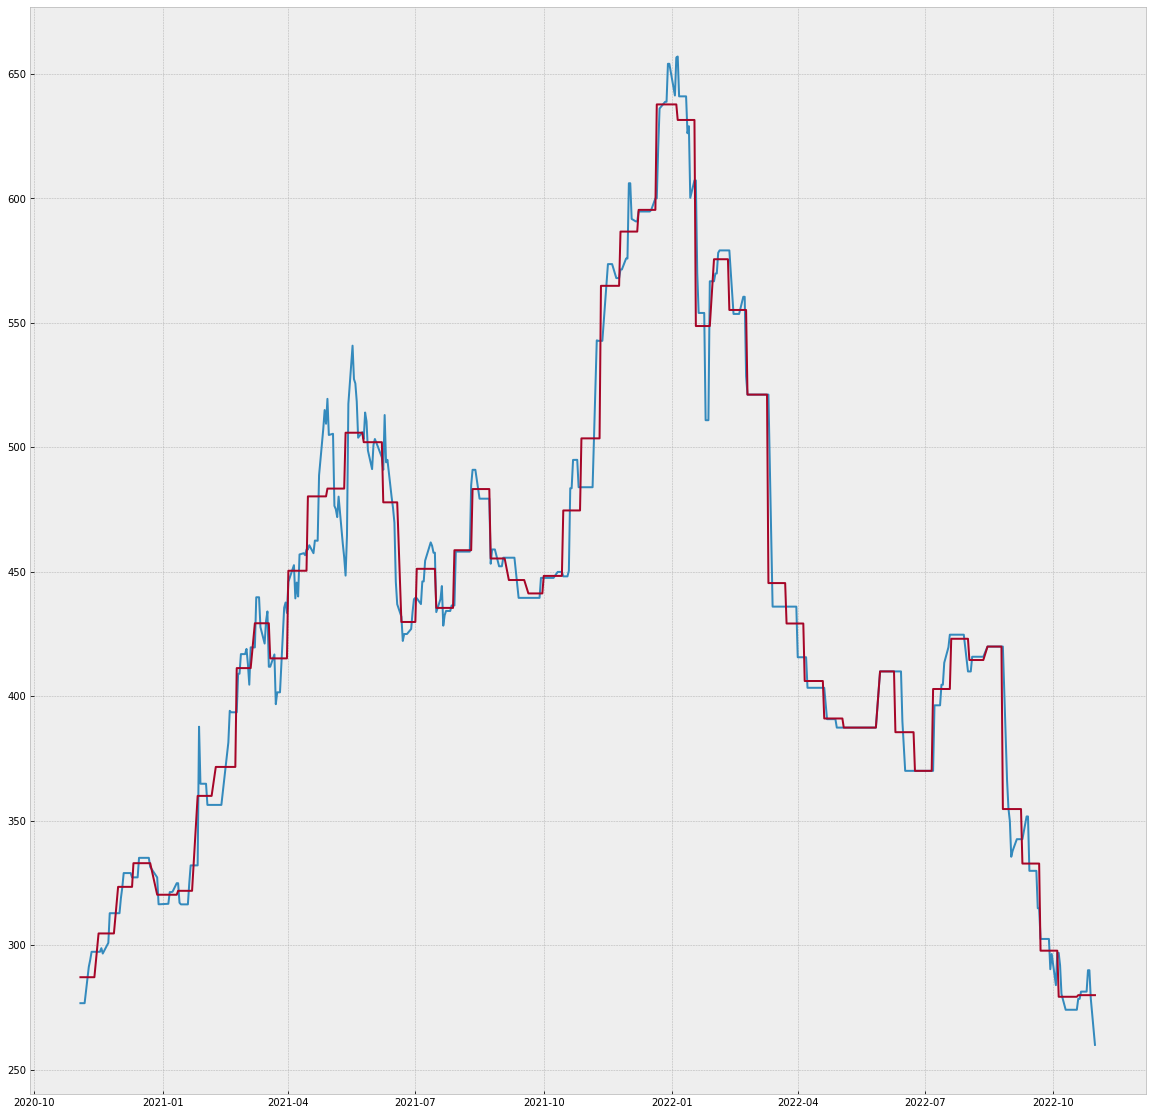

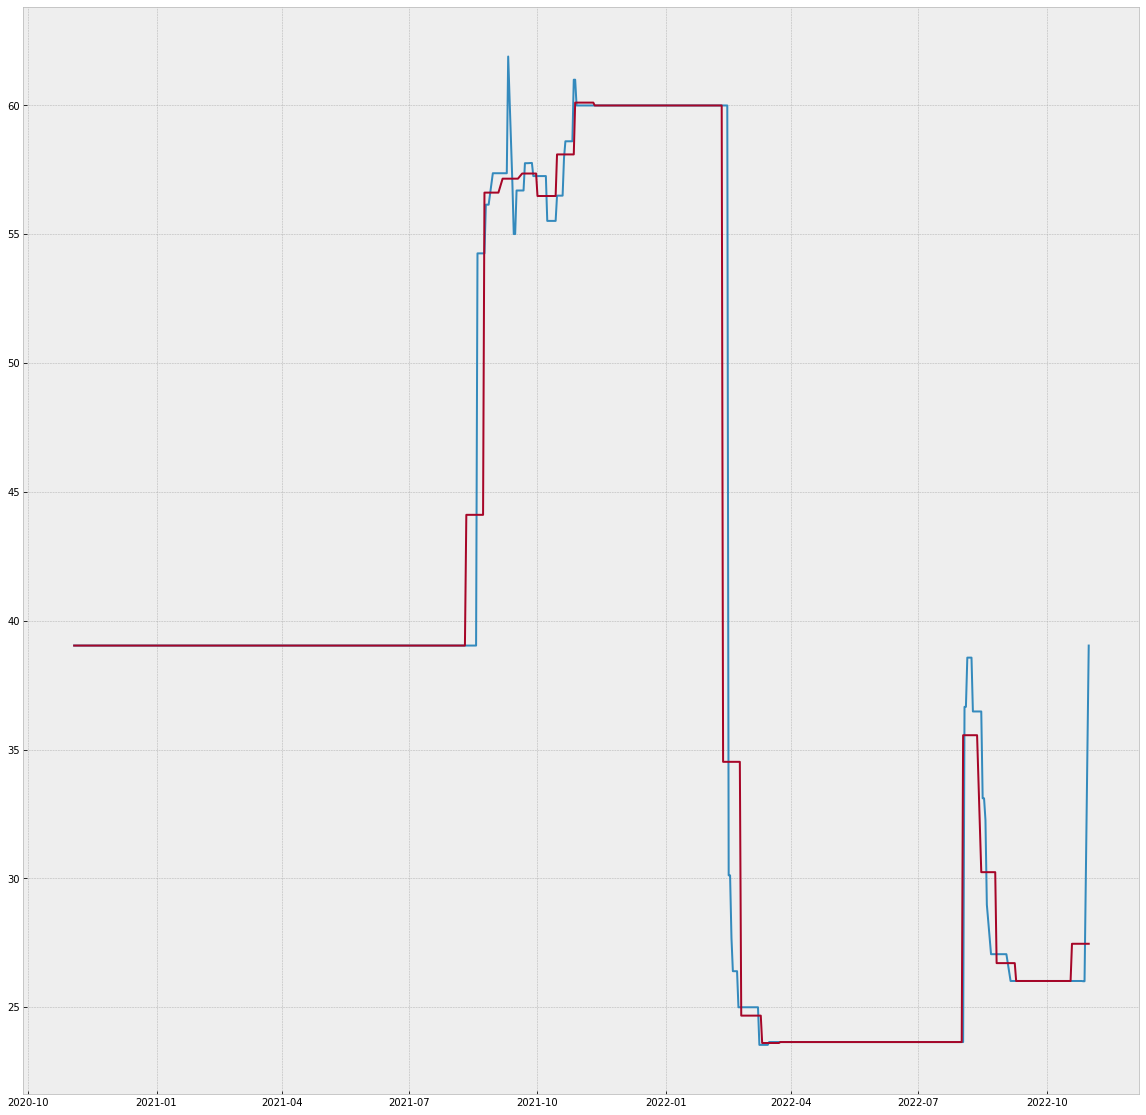

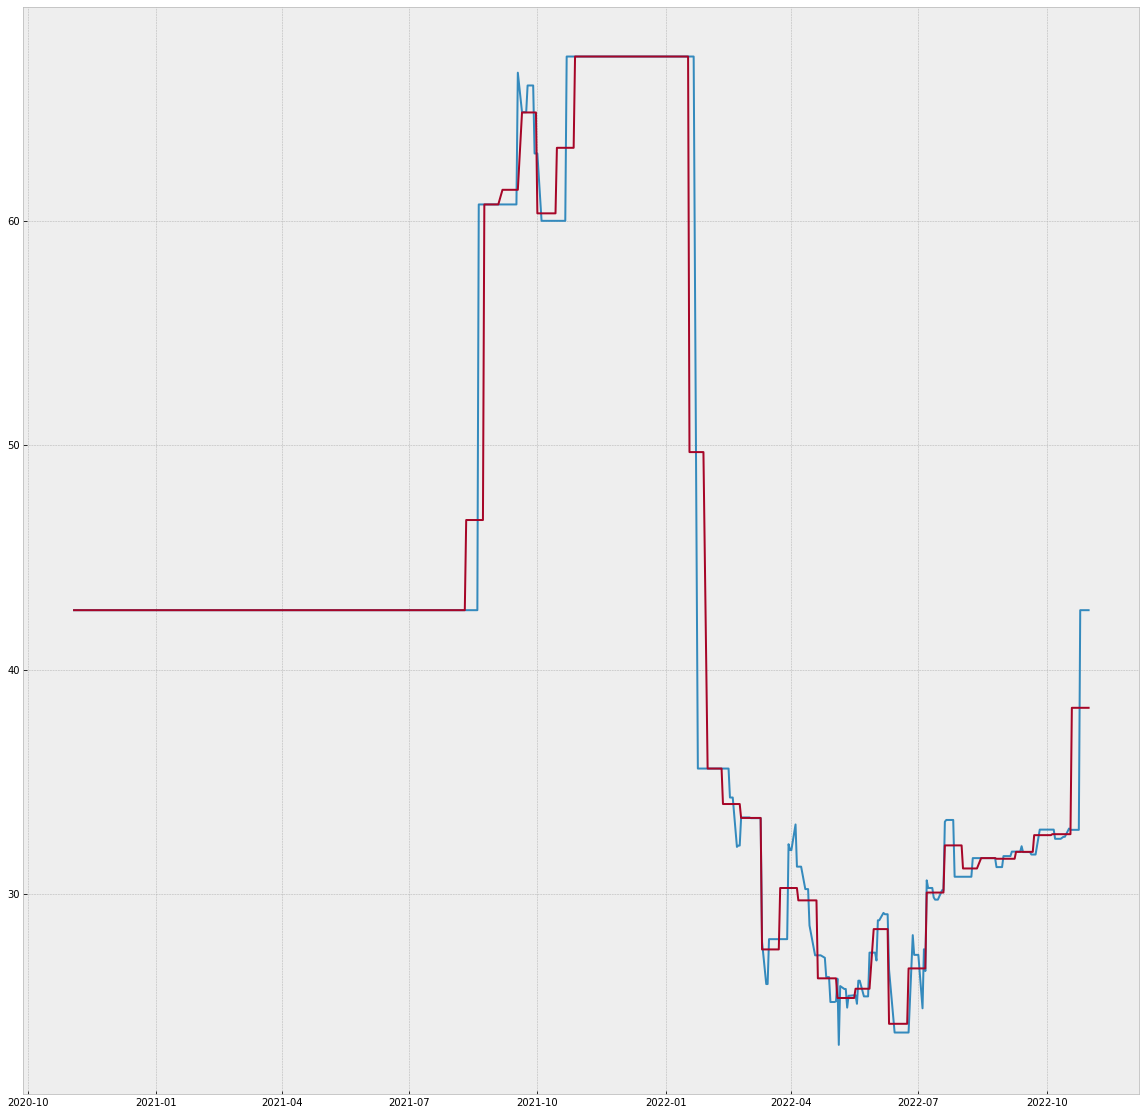

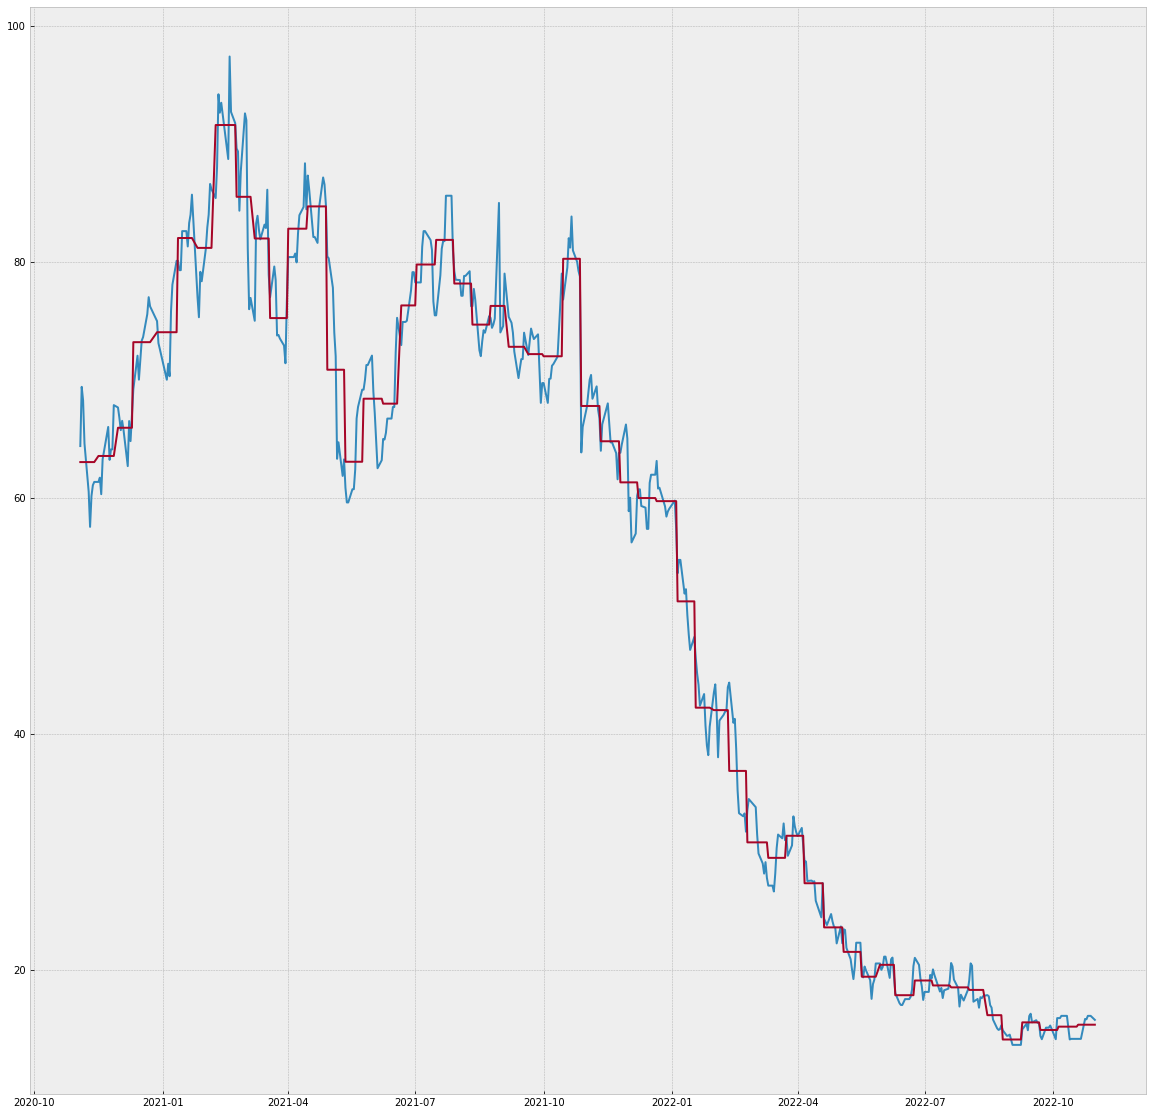

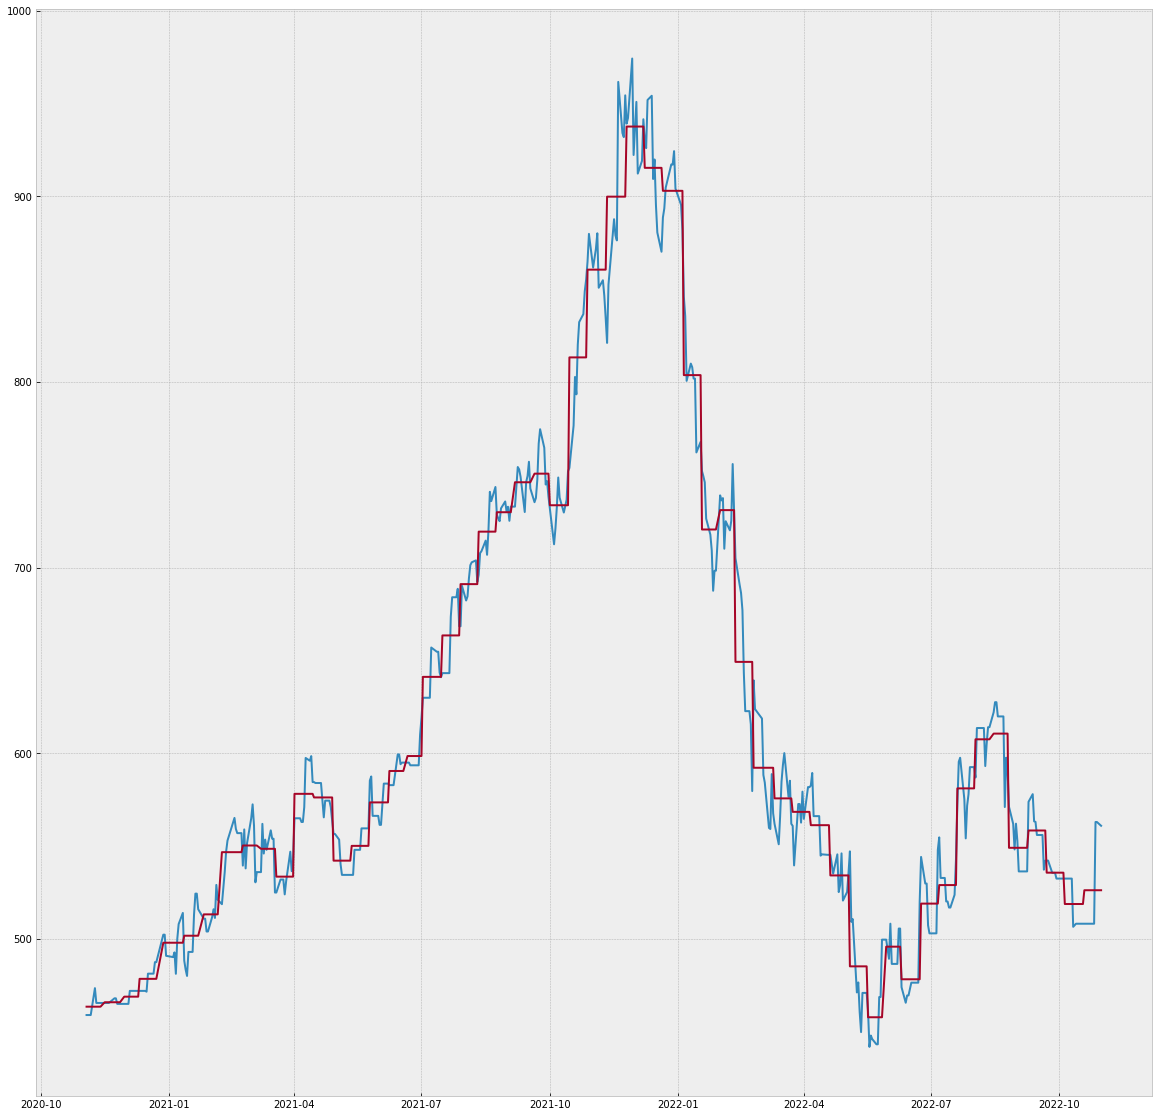

In [87]:
for i in range(0,9):
 media_plot(df2_pred_close_list[i], media_movel_dias)

# CSVs

In [88]:
analise_financas_query_fechamento.toPandas().to_csv("Analise_Melhor_Setor.csv", index=False , sep=':')
files.download("Analise_Melhor_Setor.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [89]:
analise_exploratoria_query.toPandas().to_csv("Analise_Exploratoria.csv", index=False , sep=':')
files.download("Analise_Exploratoria.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>